In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
df_basa_full=pd.read_csv('basa_original.csv')

In [3]:
df_basa_full.head()


,depth,cal BP,density,accrate,weight,volume,lycadd,lyc,Abies,Pinus,...,Botrychium,Osmunda,Pteris,Selaginella,Trilete ornamentada,Trilete indeterminada,Chaetomium,Podospora,Sordaria,Sporormiella
0,0.5,-56.90,1.5,0.46,4.3,2.866667,24200,26,1,189,...,0,0,0,0,0,0,0,0,0,0
1,5.5,-50.33,1.7,0.46,3.4,2.000000,24200,12,1,149,...,0,0,0,0,0,0,0,0,0,0
2,10.5,-42.11,1.5,0.46,3.2,2.133333,24200,58,0,206,...,0,0,0,0,0,0,0,1,0,0
3,15.5,-30.47,1.7,0.46,4.0,2.352941,24200,29,0,252,...,0,0,0,1,0,0,0,0,0,0
4,20.5,-13.25,1.7,0.09,3.2,1.882353,24200,17,0,141,...,0,0,0,0,0,0,0,0,0,0


In [6]:
non_aquatic_species = 'Abies,Pinus,Juniperus,Taxus,Betula,Corylus,Alnus,Carpinus,Salix,Ulmus,Populus,Acer,Fraxinus,Fagus,Tilia,Juglans,Castanea,Quercus caducifolio,Quercus perennifolio,Pistacia,Rhamnus,Phillyrea,Buxus,Sambucus,Viburnum,Sanguisorba,Tamarix,Thymelaeaceae,Ephedra distachya,Ephedra fragilis,Ericaceae,Hereda helix,Ilex aquifolium,Viscum album,Lonicera,Vitis,Oleaceae,Myrtus,Olea,Poaceae,Lygeum spartum,Artemisia,Cichorioideae,Asteroideae,Cardueae,Rubiaceae,Centaurea,Chenopodiaceae,Caryophyllaceae,Plantago,Brassicaceae,Saxifragaceae,Fabaceae,Genista,Lotus type,Trifolium type,Rosaceae,Ribes,Boraginaceae,Sedum,Helianthemum,Lamiaceae,Urticaceae,Rumex,Berberidaceae,Euphorbiaceae,Primulaceae,Scrophulariaceae,Papaver,Campanulaceae,Convolvulaceae,Liliaceae,Iridaceae,Crassulaceae,Ranunculaceae,Cistaceae,Galium,Apiaceae,Valerianaceae,Cerealia type,Polygonaceae,Ranunculus'

species_mapping = {
        "Dec_Querc": "Quercus caducifolio",
        "Ever_Querc": "Quercus perennifolio",
        "Ephedra dist": "Ephedra distachya",
        "Ephedra frag": "Ephedra fragilis",
        "Lygeum": "Lygeum spartum",
        "Cicho": "Cichorioideae",
        "Astroi": "Asteroideae",
        "Carduaceae": "Cardueae",
        "Rubiac": "Rubiaceae",
        "Chenopo": "Chenopodiaceae",
        "Caryphy": "Caryophyllaceae",
        "Brassicac": "Brassicaceae",
        "Saxifrag": "Saxifragaceae",
        "Boraginac": "Boraginaceae",
        "Helianthem": "Helianthemum",
        "Euphorbiac": "Euphorbiaceae",
        "Primulac": "Primulaceae",
        "Scrophulari": "Scrophulariaceae",
        "Campanulac": "Campanulaceae",
        "Valerian": "Valerianaceae",
        "Cerealia": "Cerealia type",
        "Polygon": "Polygonaceae"
    }

In [40]:
df_basa_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Columns: 137 entries, depth to Sporormiella
dtypes: float64(6), int64(131)
memory usage: 150.0 KB


In [7]:
non_aquatic_species = [s.strip() for s in non_aquatic_species.split(',')]
df_bas = df_basa_full[
    list(df_basa_full.columns[:8]) +
    [c for c in df_basa_full.columns[8:] if c in non_aquatic_species]
]

df_bas.head()

,depth,cal BP,density,accrate,weight,volume,lycadd,lyc,Abies,Pinus,...,Liliaceae,Iridaceae,Crassulaceae,Ranunculaceae,Cistaceae,Galium,Apiaceae,Valerianaceae,Polygonaceae,Ranunculus
0,0.5,-56.90,1.5,0.46,4.3,2.866667,24200,26,1,189,...,2,2,1,2,1,0,0,0,0,1
1,5.5,-50.33,1.7,0.46,3.4,2.000000,24200,12,1,149,...,0,0,0,5,0,0,1,0,0,3
2,10.5,-42.11,1.5,0.46,3.2,2.133333,24200,58,0,206,...,1,1,1,6,0,1,2,0,0,5
3,15.5,-30.47,1.7,0.46,4.0,2.352941,24200,29,0,252,...,0,0,0,4,0,1,0,0,0,2
4,20.5,-13.25,1.7,0.09,3.2,1.882353,24200,17,0,141,...,0,0,0,4,0,0,3,0,1,3


In [6]:
from statsmodels.tsa.api import VAR

species_cols = df_bas.columns[9:]

In [30]:
def granger_xy(df, x, y, maxlags=1):
    try:
        # filtrar filas válidas (ambas especies muestreadas)
        sub = df.loc[(df[x] > 0) & (df[y] > 0), ['cal BP', x, y]]
        sub = sub.sort_values('cal BP')

        # si hay pocos datos, forzar excepción
        if len(sub) < maxlags + 2:
            raise ValueError("Not enough data")

        data_tuple = pd.DataFrame({
            'X': sub[x].values,
            'Y': sub[y].values
        })

        model = VAR(data_tuple)
        results = model.fit(maxlags=maxlags)

        causality = results.test_causality(
            caused='Y',
            causing=['X'],
            kind='f'
        )

        p_value = causality.pvalue
        coefficient = results.coefs[0][1][0]  # coef X -> Y

    except Exception:
        p_value = 1
        coefficient = 0

    return p_value, coefficient


ANÁLISIS DE CAUSALIDAD DE GRANGER CON CEROS COMO NaN

VENTANA: 0_50 (filas 0-50)
Dimensiones: (51, 87)
Rango temporal: 4553.2 - -56.9 cal BP

Especies con suficientes datos: 24 de 79

Primeras 10 especies (con % de NaN):
      especie %_NaN  n_unicos
        Abies 25.5%        12
        Pinus  0.0%        44
    Juniperus  0.0%        13
       Betula  0.0%        18
      Corylus  3.9%        14
        Fagus  3.9%        11
    Ericaceae  3.9%        10
      Poaceae  0.0%        21
    Artemisia  0.0%        27
Cichorioideae 13.7%        10

Analizando 552 pares de especies...

RESULTADOS VENTANA 0_50
Total pares analizados: 552
Modelos VAR exitosos: 552 (100.0%)
Modelos fallidos: 0
Links significativos (p < 0.01): 13
  Positivos: 10 (76.9%)
  Negativos: 3 (23.1%)

Distribución de p-values (solo modelos válidos):
  p < 0.01: 13
  p < 0.05: 49
  p < 0.10: 92

VENTANA: 51_84 (filas 51-84)
Dimensiones: (34, 87)
Rango temporal: 7963.72 - 4661.7 cal BP

Especies con suficientes datos: 2

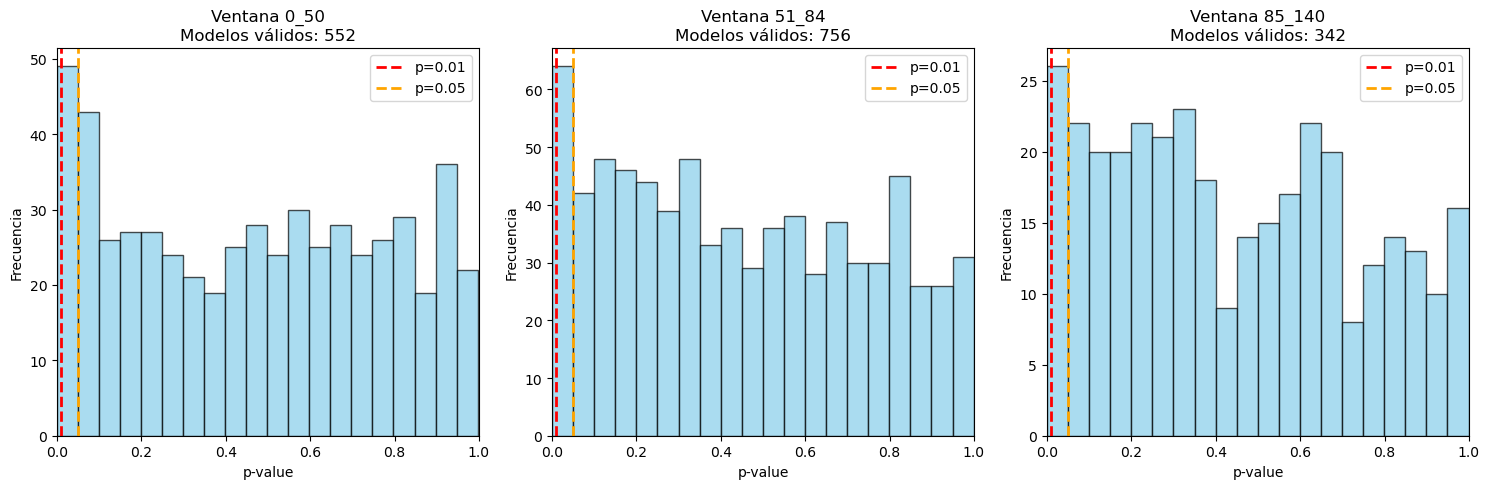


ESTADÍSTICAS DE DATOS FALTANTES (NaN)

Ventana 0_50:
  Promedio de NaN en especie causal: 3.4
  Promedio de NaN en especie respuesta: 3.4

Ventana 51_84:
  Promedio de NaN en especie causal: 3.9
  Promedio de NaN en especie respuesta: 3.9

Ventana 85_140:
  Promedio de NaN en especie causal: 5.1
  Promedio de NaN en especie respuesta: 5.1


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Definir las ventanas de tiempo
windows = {
    "0_50": (0, 50),
    "51_84": (51, 84),
    "85_140": (85, 140)
}

# Identificar las columnas de especies (desde Abies en adelante)
especies_cols = df_bas.columns[df_bas.columns.get_loc('Abies'):].tolist()

# Función para convertir ceros a NaN en columnas de especies
def convertir_ceros_a_nan(df, especies_cols):
    """
    Convierte los ceros en las columnas de especies a NaN
    porque representan "no muestra", no "ausencia"
    """
    df_mod = df.copy()
    for col in especies_cols:
        df_mod[col] = df_mod[col].replace(0, np.nan)
    return df_mod

# Función para verificar si una serie es válida para análisis
def es_serie_valida(serie, min_puntos=5, max_prop_nan=0.3):
    """
    Verifica si una serie temporal tiene suficientes datos no-NaN
    """
    # Eliminar NaN
    serie_clean = serie.dropna()
    
    # Verificar que tenemos suficientes puntos
    if len(serie_clean) < min_puntos:
        return False
    
    # Verificar proporción de NaN no sea demasiado alta
    prop_nan = serie.isna().sum() / len(serie)
    if prop_nan > max_prop_nan:
        return False
    
    # Verificar si hay variación (no todos los valores son iguales)
    if serie_clean.nunique() < 2:
        return False
    
    return True

# Función para interpolar valores NaN en una serie temporal
def interpolar_serie(serie, metodo='linear'):
    """
    Interpola valores NaN en una serie temporal
    """
    # Si hay NaN al principio o final, usar el valor válido más cercano
    serie_interp = serie.interpolate(method=metodo, limit_direction='both')
    
    # Si aún quedan NaN (por ejemplo, toda la serie es NaN), rellenar con 0
    # pero esto no debería pasar porque ya filtramos series válidas
    serie_interp = serie_interp.fillna(0)
    
    return serie_interp

# Función para calcular causalidad de Granger con manejo de NaN
def calcular_granger_con_nan(df_window_original, sp1, sp2):
    """
    Calcula la causalidad de Granger de sp1 a sp2
    con manejo especial de NaN (ceros originales)
    """
    # Extraer las series originales (con NaN)
    serie_x_original = df_window_original[sp1].copy()
    serie_y_original = df_window_original[sp2].copy()
    
    # Verificar que las series son válidas (suficientes datos no-NaN)
    if not es_serie_valida(serie_x_original) or not es_serie_valida(serie_y_original):
        return 1, 0, False, 0, 0
    
    # Registrar cuántos NaN había originalmente
    nan_x = serie_x_original.isna().sum()
    nan_y = serie_y_original.isna().sum()
    
    # Interpolar NaN para tener series completas
    serie_x = interpolar_serie(serie_x_original)
    serie_y = interpolar_serie(serie_y_original)
    
    # Invertir orden para que el tiempo fluya correctamente (de pasado a presente)
    array_x = serie_x.values[::-1]
    array_y = serie_y.values[::-1]
    
    # Crear dataframe para VAR
    data_tuple = pd.DataFrame({sp1: array_x, sp2: array_y})
    
    try:
        # Estandarizar las series
        scaler = StandardScaler()
        data_scaled = pd.DataFrame(
            scaler.fit_transform(data_tuple),
            columns=data_tuple.columns
        )
        
        # Ajustar modelo VAR
        model = VAR(data_scaled)
        
        # Seleccionar número de lags (máximo 3)
        max_lags = min(3, len(data_scaled)//3)
        if max_lags < 1:
            return 1, 0, False, nan_x, nan_y
        
        try:
            lag_selection = model.select_order(maxlags=max_lags)
            mejor_lag = lag_selection.aic
            if mejor_lag == 0 or np.isnan(mejor_lag):
                mejor_lag = 1
        except:
            mejor_lag = 1
        
        results = model.fit(maxlags=mejor_lag)
        
        # Test de causalidad
        causality = results.test_causality(caused=sp2, causing=[sp1], kind='f')
        p_value = causality.pvalue
        
        # Calcular coeficiente total
        coeficiente_total = 0
        for lag in range(mejor_lag):
            coef_idx = lag * len(results.names) + 0  # sp1 es el primero en nuestro dataframe
            coeficiente_total += results.coefs[lag][1][0]
        
        valido = True
        
    except Exception as e:
        p_value = 1
        coeficiente_total = 0
        valido = False
    
    return p_value, coeficiente_total, valido, nan_x, nan_y

# Procesar cada ventana
resultados_por_ventana = {}

print("="*70)
print("ANÁLISIS DE CAUSALIDAD DE GRANGER CON CEROS COMO NaN")
print("="*70)

for window_name, (start, end) in windows.items():
    print(f"\n{'='*50}")
    print(f"VENTANA: {window_name} (filas {start}-{end})")
    print(f"{'='*50}")
    
    # Filtrar datos para la ventana
    df_window_raw = df_bas.iloc[start:end+1].copy()
    
    # Convertir ceros a NaN en columnas de especies
    df_window = convertir_ceros_a_nan(df_window_raw, especies_cols)
    
    print(f"Dimensiones: {df_window.shape}")
    print(f"Rango temporal: {df_window['cal BP'].iloc[-1]} - {df_window['cal BP'].iloc[0]} cal BP")
    
    # Verificar que tenemos suficientes datos
    if len(df_window) < 5:
        print(f"⚠️ Ventana con muy pocos datos ({len(df_window)} filas)")
        continue
    
    # Identificar especies con suficientes datos
    especies_validas = []
    stats_especies = []
    
    for sp in especies_cols:
        serie = df_window[sp]
        n_nan = serie.isna().sum()
        prop_nan = n_nan / len(serie)
        n_unicos = serie.nunique()
        
        if es_serie_valida(serie):
            especies_validas.append(sp)
            stats_especies.append({
                'especie': sp,
                '%_NaN': f"{prop_nan*100:.1f}%",
                'n_unicos': n_unicos
            })
    
    print(f"\nEspecies con suficientes datos: {len(especies_validas)} de {len(especies_cols)}")
    
    # Mostrar algunas estadísticas de NaN
    if stats_especies:
        df_stats = pd.DataFrame(stats_especies).head(10)
        print("\nPrimeras 10 especies (con % de NaN):")
        print(df_stats.to_string(index=False))
    
    if len(especies_validas) < 3:
        print(f"⚠️ Muy pocas especies válidas (mínimo 3)")
        continue
    
    # Calcular causalidad para pares de especies válidas
    resultados = []
    pares_validos = 0
    pares_fallidos = 0
    total_nan_x = 0
    total_nan_y = 0
    
    n_especies = len(especies_validas)
    total_pares = n_especies * (n_especies - 1)
    
    print(f"\nAnalizando {total_pares} pares de especies...")
    
    for i, sp1 in enumerate(especies_validas):
        for j, sp2 in enumerate(especies_validas):
            if i != j:
                p_value, coef, valido, nan_x, nan_y = calcular_granger_con_nan(df_window, sp1, sp2)
                
                if valido:
                    pares_validos += 1
                    total_nan_x += nan_x
                    total_nan_y += nan_y
                else:
                    pares_fallidos += 1
                
                resultados.append({
                    'from': sp1,
                    'to': sp2,
                    'p_value': p_value,
                    'coefficient': coef,
                    'significant': p_value < 0.01,
                    'sign': 'positive' if coef > 0.01 else 'negative' if coef < -0.01 else 'neutral',
                    'modelo_valido': valido,
                    'nan_from': nan_x,
                    'nan_to': nan_y
                })
    
    # Convertir a DataFrame
    df_resultados = pd.DataFrame(resultados)
    resultados_por_ventana[window_name] = df_resultados
    
    # Estadísticas
    modelos_validos = df_resultados[df_resultados['modelo_valido']]
    significantes = df_resultados[df_resultados['significant']]
    
    n_links = len(significantes)
    n_positivos = len(significantes[significantes['sign'] == 'positive'])
    n_negativos = len(significantes[significantes['sign'] == 'negative'])
    
    print(f"\n{'='*30}")
    print(f"RESULTADOS VENTANA {window_name}")
    print(f"{'='*30}")
    print(f"Total pares analizados: {len(df_resultados)}")
    print(f"Modelos VAR exitosos: {len(modelos_validos)} ({len(modelos_validos)/len(df_resultados)*100:.1f}%)")
    print(f"Modelos fallidos: {len(df_resultados[~df_resultados['modelo_valido']])}")
    print(f"Links significativos (p < 0.01): {n_links}")
    
    if n_links > 0:
        print(f"  Positivos: {n_positivos} ({n_positivos/n_links*100:.1f}%)")
        print(f"  Negativos: {n_negativos} ({n_negativos/n_links*100:.1f}%)")
    
    if len(modelos_validos) > 0:
        print(f"\nDistribución de p-values (solo modelos válidos):")
        print(f"  p < 0.01: {len(modelos_validos[modelos_validos['p_value'] < 0.01])}")
        print(f"  p < 0.05: {len(modelos_validos[modelos_validos['p_value'] < 0.05])}")
        print(f"  p < 0.10: {len(modelos_validos[modelos_validos['p_value'] < 0.10])}")

# Visualización de resultados
if resultados_por_ventana:
    # Histograma de p-values (solo modelos válidos)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, (window_name, df_res) in enumerate(resultados_por_ventana.items()):
        ax = axes[idx]
        
        # Solo modelos válidos
        df_validos = df_res[df_res['modelo_valido']]
        
        if len(df_validos) > 0:
            ax.hist(df_validos['p_value'], bins=20, edgecolor='black', 
                   alpha=0.7, color='skyblue')
            ax.axvline(x=0.01, color='red', linestyle='--', label='p=0.01', linewidth=2)
            ax.axvline(x=0.05, color='orange', linestyle='--', label='p=0.05', linewidth=2)
            ax.set_xlabel('p-value')
            ax.set_ylabel('Frecuencia')
            ax.set_title(f'Ventana {window_name}\nModelos válidos: {len(df_validos)}')
            ax.legend()
            ax.set_xlim(0, 1)
        else:
            ax.text(0.5, 0.5, 'Sin modelos válidos', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Ventana {window_name}')
    
    plt.tight_layout()
    plt.savefig('histogramas_pvalues_con_nan.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Mostrar información sobre NaN
    print("\n" + "="*70)
    print("ESTADÍSTICAS DE DATOS FALTANTES (NaN)")
    print("="*70)
    
    for window_name, df_res in resultados_por_ventana.items():
        df_validos = df_res[df_res['modelo_valido']]
        if len(df_validos) > 0:
            avg_nan_from = df_validos['nan_from'].mean()
            avg_nan_to = df_validos['nan_to'].mean()
            print(f"\nVentana {window_name}:")
            print(f"  Promedio de NaN en especie causal: {avg_nan_from:.1f}")
            print(f"  Promedio de NaN en especie respuesta: {avg_nan_to:.1f}")
else:
    print("\n⚠️ No se obtuvieron resultados válidos en ninguna ventana")

Total especies: 79

Parámetros:
  Umbral p-value: 0.05
  Mínimo puntos NO CERO: 3

VENTANA: 0_50 (filas 0-50)
Filas: 51
Rango temporal: 4553.2 - -56.9

Especies válidas: 75 de 79

Primeras 10 especies:
  especie %_ceros  media  max
    Abies   25.5%   3.51   22
    Pinus    0.0% 129.06  252
Juniperus    0.0%   7.55   16
   Betula    0.0%   7.94   34
  Corylus    3.9%   5.41   19
    Alnus   58.8%   0.82    6
 Carpinus   96.1%   0.04    1
    Salix   64.7%   0.51    3
    Ulmus   49.0%   0.78    3
  Populus   78.4%   0.27    3

Analizando 5550 pares...

RESULTADOS:
  Modelos exitosos: 5550/5550 (100.0%)
  Pares analizados: 5550
  Links significativos (p < 0.05): 354 (6.38%)
    Positivos: 275 (77.7%)
    Negativos: 79 (22.3%)

  Ejemplos de links significativos:
    Olea -> Centaurea: p=0.0000, coef=0.7306
    Viscum album -> Rhamnus: p=0.0000, coef=0.6351
    Olea -> Fraxinus: p=0.0000, coef=0.7864
    Acer -> Fagus: p=0.0000, coef=0.6198
    Abies -> Ilex aquifolium: p=0.0000, coef=0.

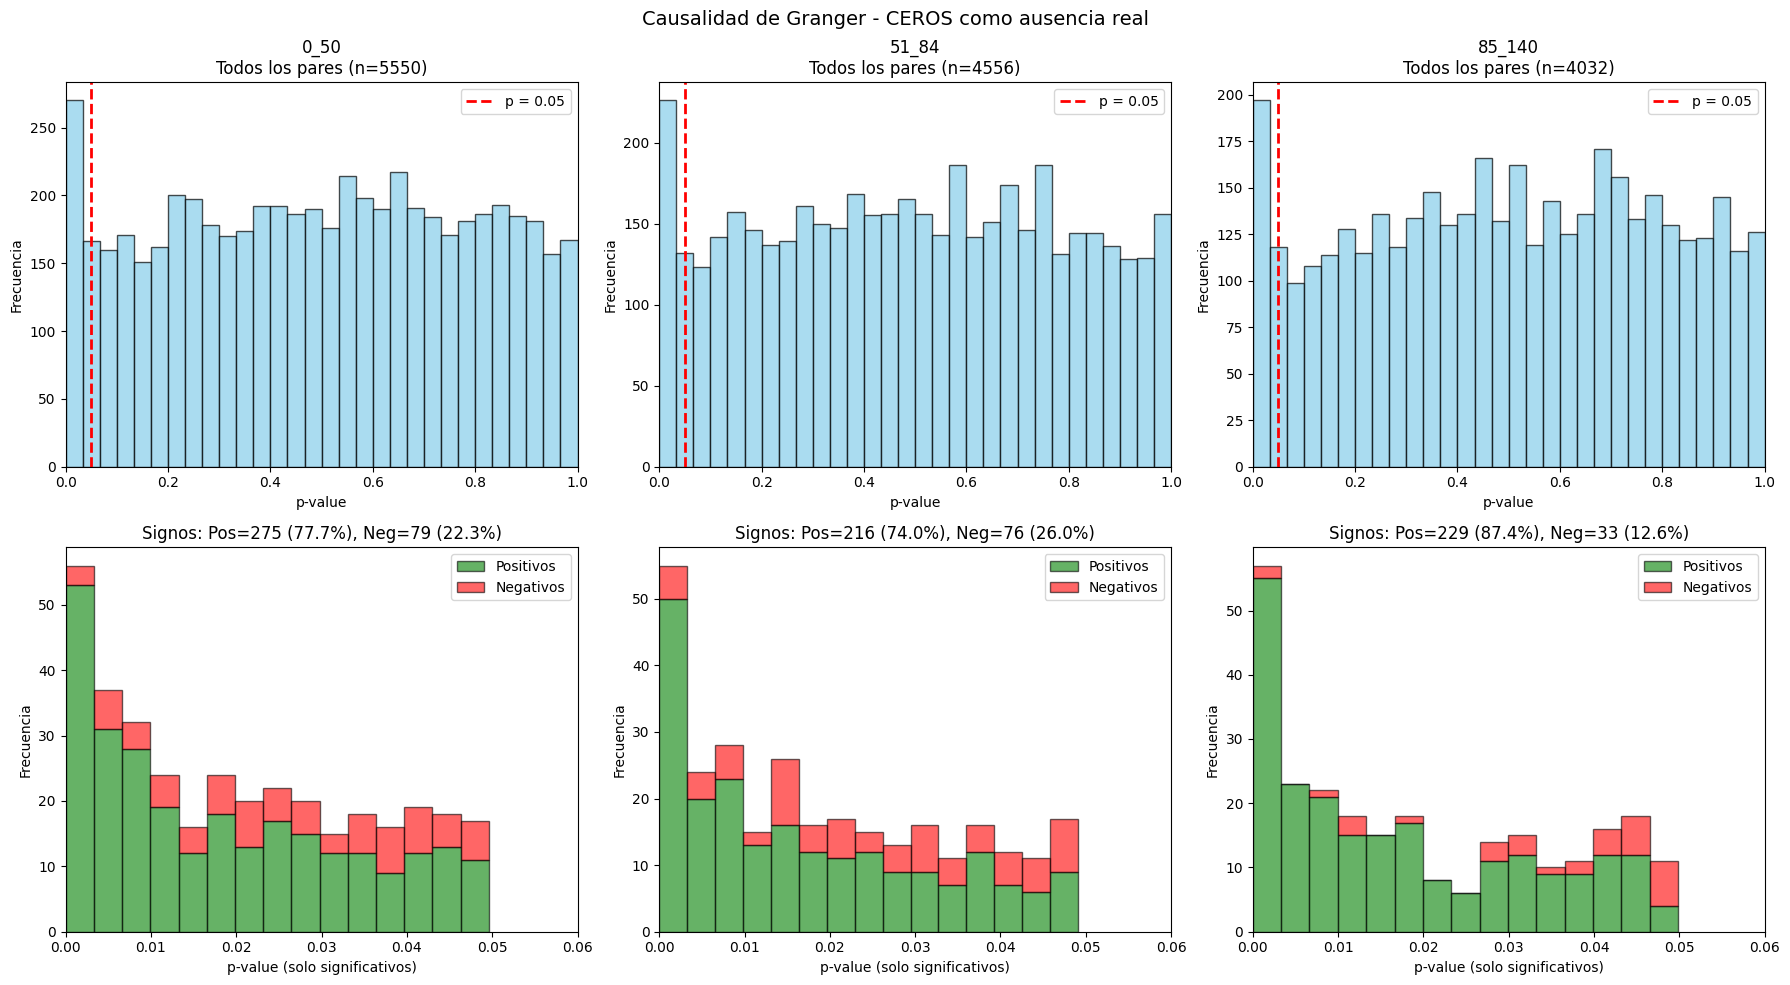


RESUMEN DE RESULTADOS POR VENTANA

 Ventana  Total pares  Links sig % sig  Positivos % Pos  Negativos % Neg
   0_50         5550        354 6.38%        275 77.7%         79 22.3%
  51_84         4556        292 6.41%        216 74.0%         76 26.0%
 85_140         4032        262 6.50%        229 87.4%         33 12.6%


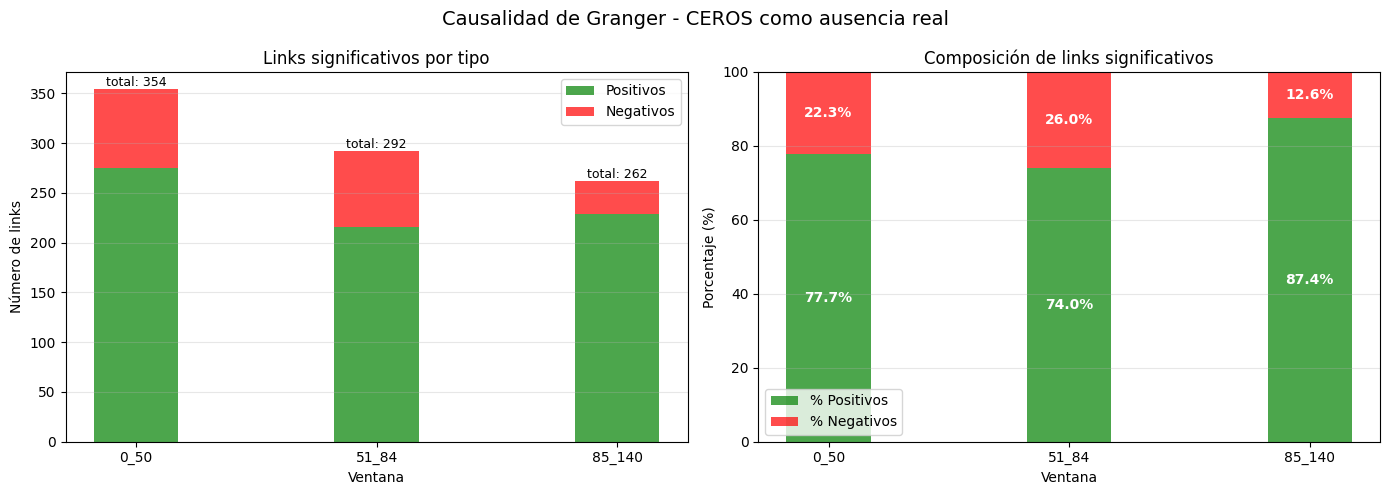


✅ Guardado: granger_0_50_p0.05_ceros_reales.csv

✅ Guardado: granger_51_84_p0.05_ceros_reales.csv

✅ Guardado: granger_85_140_p0.05_ceros_reales.csv

✅ Análisis completado - Los ceros se mantienen como ceros


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# ============================================
# CONFIGURACIÓN INICIAL
# ============================================

windows = {
    "0_50": (0, 50),
    "51_84": (51, 84),
    "85_140": (85, 140)
}

# Identificar todas las columnas de especies
especies_cols = df_bas.columns[df_bas.columns.get_loc('Abies'):].tolist()
print(f"Total especies: {len(especies_cols)}")

# ============================================
# PARÁMETROS
# ============================================
UMBRAL_P_VALUE = 0.01  # Puedes ajustar: 0.01, 0.05, 0.1
MIN_PUNTOS_SERIE = 3    # Mínimo de puntos NO CERO para considerar una especie
MIN_VARIANZA = 1e-6     # Varianza mínima para evitar series constantes

print(f"\nParámetros:")
print(f"  Umbral p-value: {UMBRAL_P_VALUE}")
print(f"  Mínimo puntos NO CERO: {MIN_PUNTOS_SERIE}")
print("="*60)

# ============================================
# FUNCIONES DE VALIDACIÓN (AHORA CON CEROS REALES)
# ============================================

def es_serie_valida(serie, min_puntos=MIN_PUNTOS_SERIE):
    """
    Verifica si una serie es válida para análisis
    Los ceros son válidos (son datos reales de ausencia)
    """
    # No hay NaN porque los ceros son datos reales
    n_puntos = len(serie)
    
    # Verificar que tenemos suficientes puntos TOTALES
    if n_puntos < min_puntos:
        return False
    
    # Verificar que no sea constante (toda cero o todo igual)
    if serie.nunique() < 2:
        return False
    
    # Verificar varianza mínima
    if serie.var() < MIN_VARIANZA:
        return False
    
    return True

def calcular_granger(df_window, sp1, sp2):
    """
    Calcula causalidad de Granger de sp1 a sp2
    Los ceros se mantienen como ceros (son ausencia real)
    """
    try:
        # Obtener series (los ceros ya están como 0)
        serie_x = df_window[sp1].copy()
        serie_y = df_window[sp2].copy()
        
        # Verificar validez de las series
        if not es_serie_valida(serie_x) or not es_serie_valida(serie_y):
            return None, None
        
        # NO INTERPOLAMOS - los ceros se mantienen como ceros
        
        # Invertir orden (crítico para el orden temporal)
        array_x = serie_x.values[::-1]
        array_y = serie_y.values[::-1]
        
        # Añadir ruido mínimo para evitar singularidad
        array_x = array_x + np.random.normal(0, 1e-8, len(array_x))
        array_y = array_y + np.random.normal(0, 1e-8, len(array_y))
        
        # Estandarizar
        data = pd.DataFrame({sp1: array_x, sp2: array_y})
        scaler = StandardScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
        
        # VAR con 1 lag (suficiente para ventanas pequeñas)
        model = VAR(data_scaled)
        results = model.fit(maxlags=1)
        
        # Test de causalidad
        causality = results.test_causality(caused=sp2, causing=[sp1], kind='f')
        p_value = causality.pvalue
        coeficiente = results.coefs[0][1][0]
        
        return p_value, coeficiente
        
    except Exception as e:
        return None, None

# ============================================
# PROCESAR CADA VENTANA
# ============================================

resultados = {}

for window_name, (start, end) in windows.items():
    print(f"\n{'='*60}")
    print(f"VENTANA: {window_name} (filas {start}-{end})")
    print(f"{'='*60}")
    
    # Extraer ventana (SIN convertir ceros a NaN)
    df_window = df_bas.iloc[start:end+1].copy()
    
    print(f"Filas: {len(df_window)}")
    print(f"Rango temporal: {df_window['cal BP'].iloc[-1]:.1f} - {df_window['cal BP'].iloc[0]:.1f}")
    
    # Identificar especies válidas (con suficientes datos NO CERO)
    especies_validas = []
    estadisticas = []
    
    for sp in especies_cols:
        serie = df_window[sp]
        n_ceros = (serie == 0).sum()
        n_no_ceros = (serie > 0).sum()
        prop_ceros = n_ceros / len(serie) * 100
        
        if es_serie_valida(serie):
            especies_validas.append(sp)
            estadisticas.append({
                'especie': sp,
                '%_ceros': f"{prop_ceros:.1f}%",
                'media': f"{serie.mean():.2f}",
                'max': serie.max()
            })
    
    print(f"\nEspecies válidas: {len(especies_validas)} de {len(especies_cols)}")
    
    # Mostrar algunas estadísticas
    if estadisticas:
        df_stats = pd.DataFrame(estadisticas).head(10)
        print("\nPrimeras 10 especies:")
        print(df_stats.to_string(index=False))
    
    if len(especies_validas) < 2:
        print(f"  ⚠️ No hay suficientes especies válidas")
        resultados[window_name] = pd.DataFrame()
        continue
    
    # Calcular todos los pares
    print(f"\nAnalizando {len(especies_validas) * (len(especies_validas)-1)} pares...")
    
    datos_pares = []
    exitosos = 0
    fallidos = 0
    
    for i, sp1 in enumerate(especies_validas):
        for j, sp2 in enumerate(especies_validas):
            if i != j:
                p_value, coeficiente = calcular_granger(df_window, sp1, sp2)
                
                if p_value is not None:
                    exitosos += 1
                    datos_pares.append({
                        'from': sp1,
                        'to': sp2,
                        'p_value': p_value,
                        'coeficiente': coeficiente,
                        'signo': 'positivo' if coeficiente > 0 else 'negativo',
                        'significativo': p_value < UMBRAL_P_VALUE
                    })
                else:
                    fallidos += 1
    
    # Guardar resultados
    if datos_pares:
        df_res = pd.DataFrame(datos_pares)
        resultados[window_name] = df_res
        
        # Estadísticas
        sig = df_res[df_res['significativo']]
        n_sig = len(sig)
        pct_sig = n_sig / len(df_res) * 100
        
        print(f"\nRESULTADOS:")
        print(f"  Modelos exitosos: {exitosos}/{exitosos+fallidos} ({exitosos/(exitosos+fallidos)*100:.1f}%)")
        print(f"  Pares analizados: {len(df_res)}")
        print(f"  Links significativos (p < {UMBRAL_P_VALUE}): {n_sig} ({pct_sig:.2f}%)")
        
        if n_sig > 0:
            n_pos = len(sig[sig['signo'] == 'positivo'])
            n_neg = len(sig[sig['signo'] == 'negativo'])
            print(f"    Positivos: {n_pos} ({n_pos/n_sig*100:.1f}%)")
            print(f"    Negativos: {n_neg} ({n_neg/n_sig*100:.1f}%)")
            
            # Mostrar algunos ejemplos
            print(f"\n  Ejemplos de links significativos:")
            ejemplos = sig.nsmallest(5, 'p_value')[['from', 'to', 'p_value', 'coeficiente']]
            for _, row in ejemplos.iterrows():
                print(f"    {row['from']} -> {row['to']}: p={row['p_value']:.4f}, coef={row['coeficiente']:.4f}")
    else:
        print(f"  ⚠️ No se obtuvieron resultados")
        resultados[window_name] = pd.DataFrame()

# ============================================
# VISUALIZACIÓN DE RESULTADOS
# ============================================

if any(len(df) > 0 for df in resultados.values()):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for idx, (window_name, df_res) in enumerate(resultados.items()):
        if len(df_res) == 0:
            continue
            
        # Fila superior: histograma de todos los p-values
        ax1 = axes[0, idx]
        ax1.hist(df_res['p_value'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        ax1.axvline(x=UMBRAL_P_VALUE, color='red', linestyle='--', linewidth=2, 
                   label=f'p = {UMBRAL_P_VALUE}')
        ax1.set_xlabel('p-value')
        ax1.set_ylabel('Frecuencia')
        ax1.set_title(f'{window_name}\nTodos los pares (n={len(df_res)})')
        ax1.legend()
        ax1.set_xlim(0, 1)
        
        # Fila inferior: histograma de signos (solo significativos)
        ax2 = axes[1, idx]
        sig = df_res[df_res['significativo']]
        
        if len(sig) > 0:
            pos = sig[sig['signo'] == 'positivo']['p_value']
            neg = sig[sig['signo'] == 'negativo']['p_value']
            
            ax2.hist([pos, neg], bins=15, edgecolor='black',
                    label=['Positivos', 'Negativos'],
                    color=['green', 'red'], alpha=0.6, stacked=True)
            ax2.set_xlabel('p-value (solo significativos)')
            ax2.set_ylabel('Frecuencia')
            ax2.set_title(f'Signos: Pos={len(pos)} ({len(pos)/len(sig)*100:.1f}%), Neg={len(neg)} ({len(neg)/len(sig)*100:.1f}%)')
            ax2.legend()
            ax2.set_xlim(0, UMBRAL_P_VALUE*1.2)
        else:
            ax2.text(0.5, 0.5, 'Sin relaciones significativas', 
                    ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Sin datos')
    
    plt.suptitle('Causalidad de Granger - CEROS como ausencia real', fontsize=14)
    plt.tight_layout()
    plt.savefig('histogramas_granger_ceros_reales.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================
# TABLA DE RESULTADOS
# ============================================
print("\n" + "="*70)
print("RESUMEN DE RESULTADOS POR VENTANA")
print("="*70)

tabla = []
for window_name, df_res in resultados.items():
    if len(df_res) > 0:
        sig = df_res[df_res['significativo']]
        n_sig = len(sig)
        pct_sig = n_sig/len(df_res)*100
        
        if n_sig > 0:
            n_pos = len(sig[sig['signo'] == 'positivo'])
            n_neg = len(sig[sig['signo'] == 'negativo'])
            pct_pos = n_pos/n_sig*100
            pct_neg = n_neg/n_sig*100
        else:
            n_pos = n_neg = 0
            pct_pos = pct_neg = 0
        
        tabla.append({
            'Ventana': window_name,
            'Total pares': len(df_res),
            'Links sig': n_sig,
            '% sig': f"{pct_sig:.2f}%",
            'Positivos': n_pos,
            '% Pos': f"{pct_pos:.1f}%",
            'Negativos': n_neg,
            '% Neg': f"{pct_neg:.1f}%"
        })

df_tabla = pd.DataFrame(tabla)
print("\n", df_tabla.to_string(index=False))

# ============================================
# GRÁFICO DE BARRAS
# ============================================

if len(tabla) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ventanas = [row['Ventana'] for row in tabla]
    positivos = [row['Positivos'] for row in tabla]
    negativos = [row['Negativos'] for row in tabla]
    totales = [row['Links sig'] for row in tabla]
    
    x = np.arange(len(ventanas))
    width = 0.35
    
    # Gráfico 1: Número de links
    ax1.bar(x, positivos, width, label='Positivos', color='green', alpha=0.7)
    ax1.bar(x, negativos, width, bottom=positivos, label='Negativos', color='red', alpha=0.7)
    ax1.set_xlabel('Ventana')
    ax1.set_ylabel('Número de links')
    ax1.set_title('Links significativos por tipo')
    ax1.set_xticks(x)
    ax1.set_xticklabels(ventanas)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    for i, total in enumerate(totales):
        ax1.text(i, total + 0.5, f'total: {total}', ha='center', va='bottom', fontsize=9)
    
    # Gráfico 2: Porcentajes
    pct_pos = [float(row['% Pos'].replace('%', '')) for row in tabla]
    pct_neg = [float(row['% Neg'].replace('%', '')) for row in tabla]
    
    ax2.bar(x, pct_pos, width, label='% Positivos', color='green', alpha=0.7)
    ax2.bar(x, pct_neg, width, bottom=pct_pos, label='% Negativos', color='red', alpha=0.7)
    ax2.set_xlabel('Ventana')
    ax2.set_ylabel('Porcentaje (%)')
    ax2.set_title('Composición de links significativos')
    ax2.set_xticks(x)
    ax2.set_xticklabels(ventanas)
    ax2.legend()
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3, axis='y')
    
    for i, (p, n) in enumerate(zip(pct_pos, pct_neg)):
        if p > 0:
            ax2.text(i, p/2, f'{p:.1f}%', ha='center', va='center', color='white', fontweight='bold')
        if n > 0:
            ax2.text(i, p + n/2, f'{n:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    
    plt.suptitle('Causalidad de Granger - CEROS como ausencia real', fontsize=14)
    plt.tight_layout()
    plt.savefig('porcentajes_granger_ceros_reales.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================
# GUARDAR RESULTADOS
# ============================================
for window_name, df_res in resultados.items():
    if len(df_res) > 0:
        df_res.to_csv(f'granger_{window_name}_p{UMBRAL_P_VALUE}_ceros_reales.csv', index=False)
        print(f"\n✅ Guardado: granger_{window_name}_p{UMBRAL_P_VALUE}_ceros_reales.csv")

print("\n" + "="*70)
print("✅ Análisis completado - Los ceros se mantienen como ceros")
print("="*70)

Total especies: 79

Parámetros:
  Umbral p-value: 0.01
  Mínimo puntos totales: 5
  Mínimo puntos presencia: 3
  Splines base: 140
  Lambda: 0.01
  Grid search: False

PASO 1: DATOS ORIGINALES (ceros incluidos)

Primeras 20 especies (% de ceros):
  especie  presencia  ceros %_ceros
    Abies         47     93   66.4%
    Pinus        140      0    0.0%
Juniperus        140      0    0.0%
    Taxus          6    134   95.7%
   Betula        140      0    0.0%
  Corylus        138      2    1.4%
    Alnus         37    103   73.6%
 Carpinus          3    137   97.9%
    Salix         79     61   43.6%
    Ulmus         84     56   40.0%
  Populus         31    109   77.9%
     Acer         13    127   90.7%
 Fraxinus         48     92   65.7%
    Fagus         55     85   60.7%
    Tilia         53     87   62.1%
  Juglans         18    122   87.1%
 Castanea         17    123   87.9%
 Pistacia         32    108   77.1%
  Rhamnus         18    122   87.1%
Phillyrea          2    138   98.

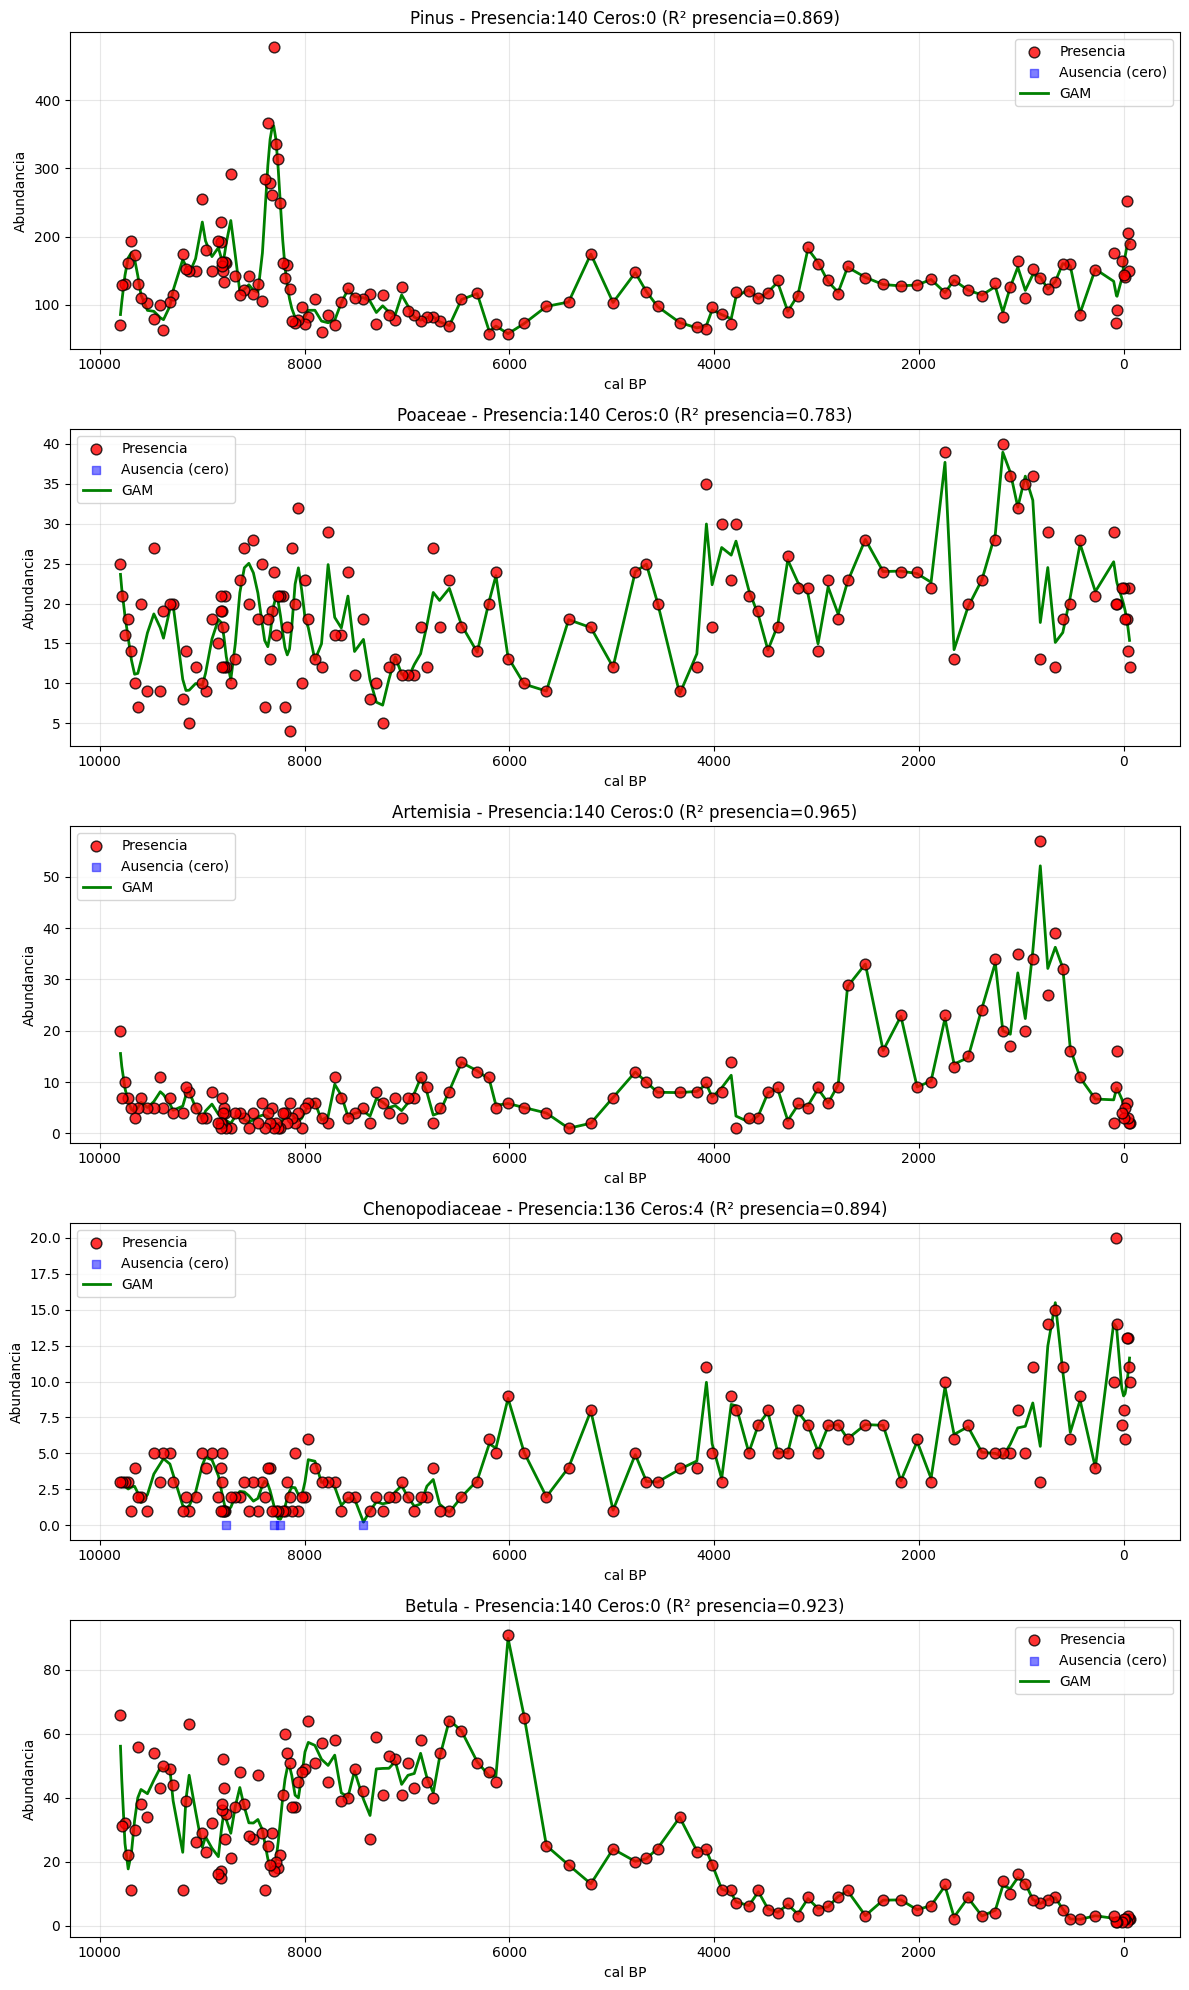


Especies válidas para análisis Granger: 75

VENTANA: 0_50
  Pares analizados: 5550
  Links significativos (p<0.01): 602 (10.85%)
    Positivos: 345 (57.3%)
    Negativos: 257 (42.7%)

VENTANA: 51_84
  Pares analizados: 5550
  Links significativos (p<0.01): 692 (12.47%)
    Positivos: 369 (53.3%)
    Negativos: 323 (46.7%)

VENTANA: 85_140
  Pares analizados: 5550
  Links significativos (p<0.01): 1276 (22.99%)
    Positivos: 706 (55.3%)
    Negativos: 570 (44.7%)


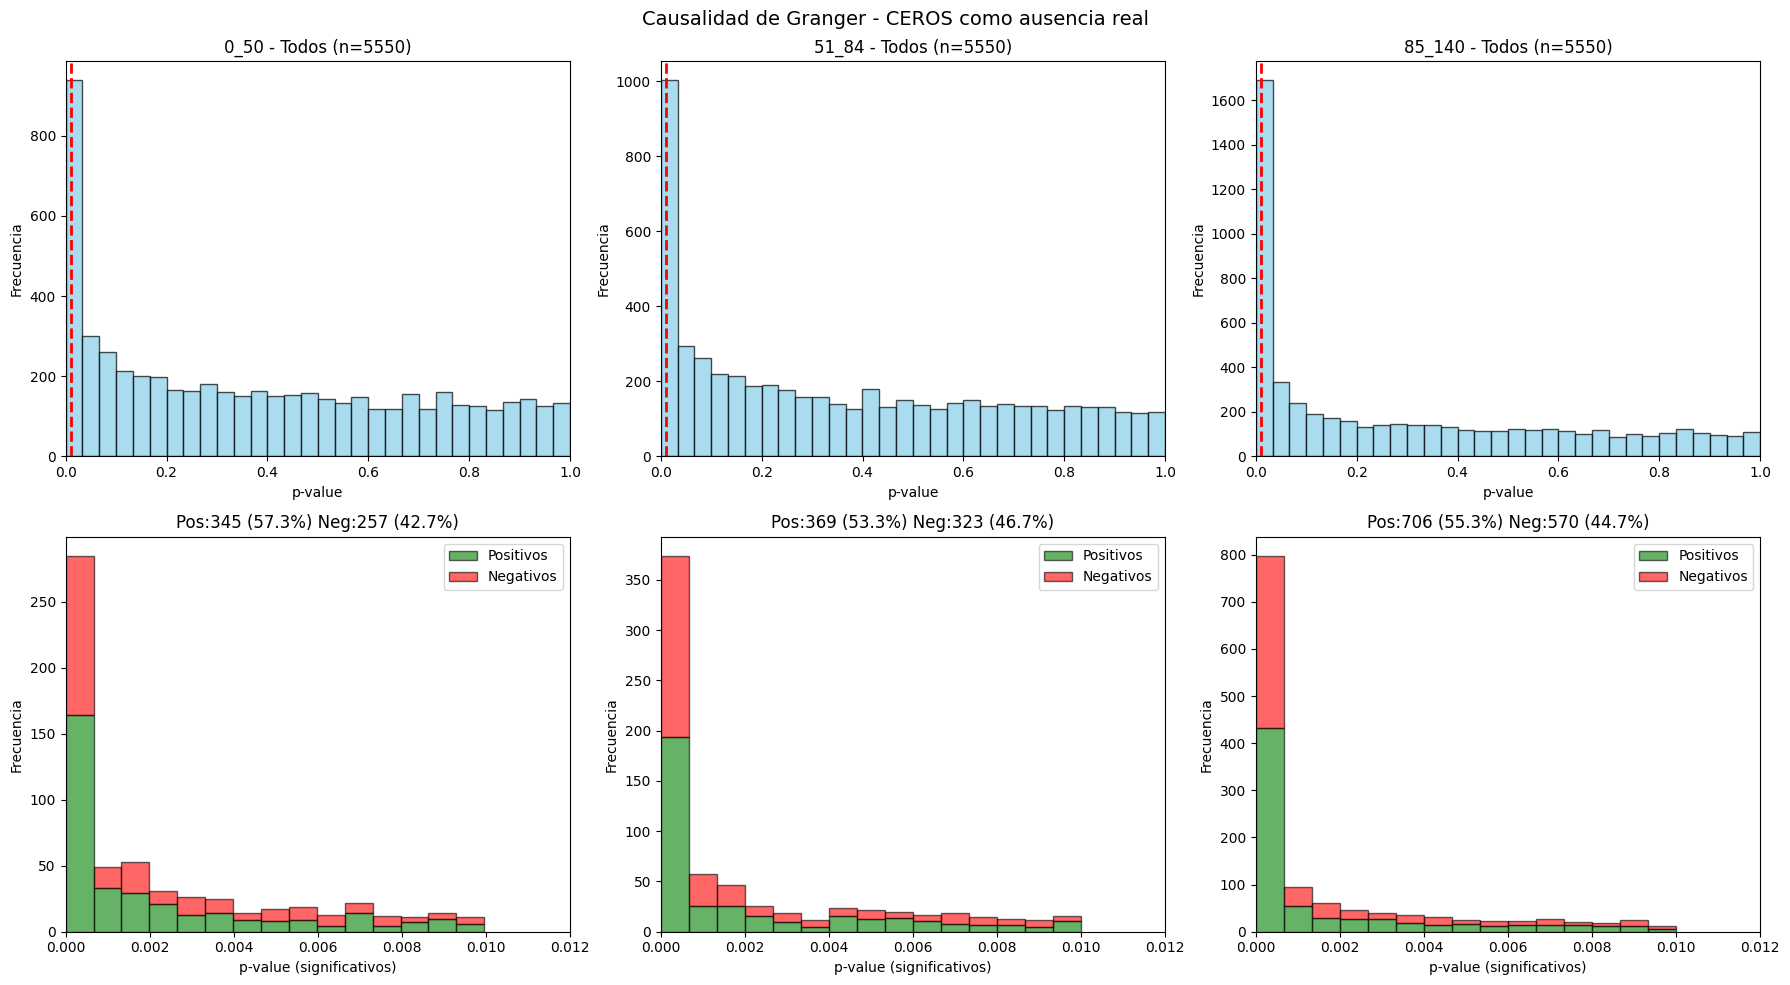


RESUMEN FINAL POR VENTANA

 Ventana  Total pares  Links sig  % sig  Positivos % Pos  Negativos % Neg
   0_50         5550        602 10.85%        345 57.3%        257 42.7%
  51_84         5550        692 12.47%        369 53.3%        323 46.7%
 85_140         5550       1276 22.99%        706 55.3%        570 44.7%

RESUMEN GLOBAL

Total p-values analizados (todas ventanas): 16650
Media global: 0.3550
Mediana global: 0.2849
p < 0.01: 2570 (15.44%)
p < 0.05: 4130 (24.80%)

Test de Kolmogorov-Smirnov (vs uniforme):
  Estadístico: 0.2263
  p-value: 0.0000

✅ Análisis completado - CEROS como ausencia real


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')

# ============================================
# CONFIGURACIÓN - CEROS SON DATOS REALES
# ============================================

windows = {
    "0_50": (0, 50),
    "51_84": (51, 84),
    "85_140": (85, 140)
}

especies_cols = df_bas.columns[df_bas.columns.get_loc('Abies'):].tolist()
print(f"Total especies: {len(especies_cols)}")

# PARÁMETROS
UMBRAL_P_VALUE = 0.01
MIN_PUNTOS_ESPECIE = 5      # Mínimo puntos TOTALES (incluyendo ceros)
MIN_PRESENCIA = 3            # Mínimo puntos con PRESENCIA (>0) para evitar especies casi siempre ausentes

# GAM
N_SPLINES_BASE = 140         # Reducido porque tenemos ceros reales
LAMBDA_GAM = 0.01             # Algo de suavizado
USE_GRIDSEARCH = False
MIN_PUNTOS_GAM = 8           # Mínimo para ajustar GAM

print(f"\nParámetros:")
print(f"  Umbral p-value: {UMBRAL_P_VALUE}")
print(f"  Mínimo puntos totales: {MIN_PUNTOS_ESPECIE}")
print(f"  Mínimo puntos presencia: {MIN_PRESENCIA}")
print(f"  Splines base: {N_SPLINES_BASE}")
print(f"  Lambda: {LAMBDA_GAM}")
print(f"  Grid search: {USE_GRIDSEARCH}")
print("="*60)

# ============================================
# FUNCIONES - SIN CONVERTIR CEROS A NAN
# ============================================

def es_serie_valida(serie):
    """
    Verifica si una serie es válida para análisis
    Los ceros son datos válidos (ausencia)
    """
    # Verificar longitud mínima
    if len(serie) < MIN_PUNTOS_ESPECIE:
        return False
    
    # Verificar que tenga suficientes presencias (>0)
    n_presencia = (serie > 0).sum()
    if n_presencia < MIN_PRESENCIA:
        return False
    
    # Verificar que no sea constante (todo cero o todo igual)
    if serie.nunique() < 2:
        return False
    
    return True

def reconstruir_serie_gam_con_ceros(df_original):
    """
    Reconstruye con GAM pero RESPETANDO LOS CEROS como datos reales
    """
    tiempo = df_original['cal BP'].values
    df_reconstruido = df_original.copy()
    
    print("\n=== RECONSTRUYENDO CON GAM (RESPETANDO CEROS) ===")
    
    estadisticas = []
    especies_procesadas = 0
    
    for idx, sp in enumerate(especies_cols):
        if idx % 10 == 0 and idx > 0:
            print(f"  Procesadas {idx}/{len(especies_cols)} especies")
            
        serie = df_original[sp].copy()
        
        # Verificar validez (ahora los ceros cuentan)
        if not es_serie_valida(serie):
            continue
            
        # TODOS los puntos son válidos (los ceros también)
        tiempo_valido = tiempo.reshape(-1, 1)
        valores = serie.values
        
        n_presencia = (valores > 0).sum()
        n_ceros = (valores == 0).sum()
        
        try:
            # Calcular número de splines (máx 30 para no sobreajustar)
            n_splines_adaptativo = N_SPLINES_BASE
            
            # Crear GAM
            gam = LinearGAM(s(0, n_splines=n_splines_adaptativo))
            
            if USE_GRIDSEARCH and len(valores) > MIN_PUNTOS_GAM * 2:
                # Búsqueda de lambda
                lam_range = np.logspace(-2, 2, 15)
                gam.gridsearch(tiempo_valido, valores, lam=lam_range, progress=False)
                lambda_opt = gam.lam[0][0]
            else:
                gam.lam = LAMBDA_GAM
                gam.fit(tiempo_valido, valores)
                lambda_opt = LAMBDA_GAM
            
            # Predecir
            predicciones = gam.predict(tiempo_valido)
            predicciones = np.maximum(predicciones, 0)  # No negativos
            
            # Guardar
            df_reconstruido[sp] = predicciones
            
            # Métricas (solo en puntos con presencia para no inflar R² con ceros)
            mask_presencia = valores > 0
            if mask_presencia.sum() > 2:
                pred_presencia = predicciones[mask_presencia]
                obs_presencia = valores[mask_presencia]
                r2_presencia = np.corrcoef(obs_presencia, pred_presencia)[0,1]**2
            else:
                r2_presencia = np.nan
            
            # Error en ceros (cuánto se equivoca cuando debería ser cero)
            mask_ceros = valores == 0
            error_ceros = np.mean(predicciones[mask_ceros]) if mask_ceros.any() else 0
            
            estadisticas.append({
                'especie': sp,
                'puntos': len(valores),
                'presencia': n_presencia,
                '%_ceros': f"{n_ceros/len(valores)*100:.1f}%",
                'splines': n_splines_adaptativo,
                'lambda': f'{lambda_opt:.4f}',
                'r2_presencia': f'{r2_presencia:.3f}' if not np.isnan(r2_presencia) else 'NA',
                'error_ceros': f'{error_ceros:.3f}'
            })
            
            especies_procesadas += 1
            
        except Exception as e:
            # Si GAM falla, mantener datos originales
            print(f"    ⚠️ {sp}: usando datos originales")
            df_reconstruido[sp] = serie
    
    # Mostrar estadísticas
    if estadisticas:
        df_stats = pd.DataFrame(estadisticas)
        print(f"\nEspecies procesadas con GAM: {especies_procesadas}")
        print(f"\nEstadísticas de ajuste:")
        print(f"  Presencia promedio: {df_stats['presencia'].mean():.1f} puntos")
        print(f"  % ceros promedio: {df_stats['%_ceros'].astype(str).str.replace('%','').astype(float).mean():.1f}%")
        
        # Mostrar algunas especies
        print("\nEjemplos de ajuste (primeras 10):")
        print(df_stats.head(10).to_string(index=False))
    
    return df_reconstruido, estadisticas

def visualizar_ajuste_con_ceros(df_original, df_reconstruido, especies_ejemplo):
    """
    Visualiza el ajuste diferenciando presencias y ceros
    """
    tiempo = df_original['cal BP'].values
    
    n_plots = len(especies_ejemplo)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4*n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    for idx, sp in enumerate(especies_ejemplo):
        ax = axes[idx]
        
        # Datos originales
        original = df_original[sp].values
        
        # Separar presencias (>0) y ceros
        mask_presencia = original > 0
        mask_ceros = original == 0
        
        # Datos reconstruidos
        reconstruido = df_reconstruido[sp].values
        
        # Plot presencias
        ax.scatter(tiempo[mask_presencia], original[mask_presencia], 
                  color='red', s=60, alpha=0.8, label='Presencia', zorder=5, edgecolor='black')
        
        # Plot ceros
        ax.scatter(tiempo[mask_ceros], original[mask_ceros], 
                  color='blue', s=30, alpha=0.5, label='Ausencia (cero)', zorder=4, marker='s')
        
        # Línea GAM
        ax.plot(tiempo, reconstruido, 'g-', linewidth=2, label='GAM', zorder=3)
        
        # Estadísticas
        n_presencia = mask_presencia.sum()
        n_ceros = mask_ceros.sum()
        
        if n_presencia > 2:
            r2 = np.corrcoef(original[mask_presencia], reconstruido[mask_presencia])[0,1]**2
            ax.set_title(f'{sp} - Presencia:{n_presencia} Ceros:{n_ceros} (R² presencia={r2:.3f})')
        else:
            ax.set_title(f'{sp} - Presencia:{n_presencia} Ceros:{n_ceros}')
        
        ax.set_xlabel('cal BP')
        ax.set_ylabel('Abundancia')
        ax.invert_xaxis()
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('ajuste_gam_con_ceros.png', dpi=300, bbox_inches='tight')
    plt.show()

def calcular_granger_con_ceros(df_reconstruido, window_name, start, end, especies_validas):
    """
    Calcula causalidad de Granger para una ventana
    """
    df_window = df_reconstruido.iloc[start:end+1].copy()
    
    resultados = []
    
    for i, sp1 in enumerate(especies_validas):
        for j, sp2 in enumerate(especies_validas):
            if i != j:
                try:
                    # Series (ya reconstruidas por GAM)
                    array_x = df_window[sp1].values[::-1]
                    array_y = df_window[sp2].values[::-1]
                    
                    # Añadir ruido mínimo
                    array_x = array_x + np.random.normal(0, 1e-8, len(array_x))
                    array_y = array_y + np.random.normal(0, 1e-8, len(array_y))
                    
                    # VAR
                    data = pd.DataFrame({sp1: array_x, sp2: array_y})
                    scaler = StandardScaler()
                    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
                    
                    model = VAR(data_scaled)
                    results = model.fit(maxlags=1)
                    
                    # Test de causalidad
                    causality = results.test_causality(caused=sp2, causing=[sp1], kind='f')
                    p_value = causality.pvalue
                    coeficiente = results.coefs[0][1][0]
                    
                    resultados.append({
                        'from': sp1,
                        'to': sp2,
                        'p_value': p_value,
                        'coeficiente': coeficiente,
                        'signo': 'positivo' if coeficiente > 0 else 'negativo'
                    })
                    
                except:
                    continue
    
    return pd.DataFrame(resultados)

# ============================================
# EJECUCIÓN PRINCIPAL
# ============================================

# 1. Preparar datos (NO convertir ceros a NaN)
print("\n" + "="*60)
print("PASO 1: DATOS ORIGINALES (ceros incluidos)")
print("="*60)

# Estadísticas de ceros/presencias
stats_globales = []
for sp in especies_cols[:20]:  # Primeras 20
    serie = df_bas[sp]
    n_ceros = (serie == 0).sum()
    n_presencia = (serie > 0).sum()
    if n_presencia > 0:
        stats_globales.append({
            'especie': sp,
            'presencia': n_presencia,
            'ceros': n_ceros,
            '%_ceros': f"{n_ceros/len(serie)*100:.1f}%"
        })

df_stats_global = pd.DataFrame(stats_globales)
print("\nPrimeras 20 especies (% de ceros):")
print(df_stats_global.to_string(index=False))

# 2. Reconstruir con GAM (respetando ceros)
df_reconstruido, estadisticas_gam = reconstruir_serie_gam_con_ceros(df_bas)

# 3. Visualizar ajuste
especies_para_ver = ['Pinus', 'Quercus', 'Poaceae', 'Artemisia', 'Chenopodiaceae', 'Betula']
especies_disponibles = [sp for sp in especies_para_ver if sp in especies_cols]
if especies_disponibles:
    visualizar_ajuste_con_ceros(df_bas, df_reconstruido, especies_disponibles)

# 4. Identificar especies válidas para Granger
especies_validas = []
for sp in especies_cols:
    if es_serie_valida(df_bas[sp]):  # Usamos datos originales para validar
        especies_validas.append(sp)

print(f"\nEspecies válidas para análisis Granger: {len(especies_validas)}")

# 5. Calcular Granger por ventanas
resultados = {}
todos_p_values = []

for window_name, (start, end) in windows.items():
    print(f"\n{'='*50}")
    print(f"VENTANA: {window_name}")
    print(f"{'='*50}")
    
    df_res = calcular_granger_con_ceros(df_reconstruido, window_name, start, end, especies_validas)
    resultados[window_name] = df_res
    
    if len(df_res) > 0:
        todos_p_values.extend(df_res['p_value'].values)
        
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        print(f"  Pares analizados: {len(df_res)}")
        print(f"  Links significativos (p<{UMBRAL_P_VALUE}): {len(sig)} ({len(sig)/len(df_res)*100:.2f}%)")
        
        if len(sig) > 0:
            n_pos = len(sig[sig['signo'] == 'positivo'])
            n_neg = len(sig[sig['signo'] == 'negativo'])
            print(f"    Positivos: {n_pos} ({n_pos/len(sig)*100:.1f}%)")
            print(f"    Negativos: {n_neg} ({n_neg/len(sig)*100:.1f}%)")

# ============================================
# VISUALIZACIÓN DE RESULTADOS
# ============================================

if any(len(df) > 0 for df in resultados.values()):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for idx, (window_name, df_res) in enumerate(resultados.items()):
        if len(df_res) == 0:
            continue
            
        # Histograma general
        ax1 = axes[0, idx]
        ax1.hist(df_res['p_value'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        ax1.axvline(x=UMBRAL_P_VALUE, color='red', linestyle='--', linewidth=2)
        ax1.set_xlabel('p-value')
        ax1.set_ylabel('Frecuencia')
        ax1.set_title(f'{window_name} - Todos (n={len(df_res)})')
        ax1.set_xlim(0, 1)
        
        # Signos
        ax2 = axes[1, idx]
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        
        if len(sig) > 0:
            pos = sig[sig['signo'] == 'positivo']['p_value']
            neg = sig[sig['signo'] == 'negativo']['p_value']
            
            ax2.hist([pos, neg], bins=15, edgecolor='black',
                    label=['Positivos', 'Negativos'],
                    color=['green', 'red'], alpha=0.6, stacked=True)
            ax2.set_xlabel('p-value (significativos)')
            ax2.set_ylabel('Frecuencia')
            ax2.set_title(f'Pos:{len(pos)} ({len(pos)/len(sig)*100:.1f}%) Neg:{len(neg)} ({len(neg)/len(sig)*100:.1f}%)')
            ax2.legend()
            ax2.set_xlim(0, UMBRAL_P_VALUE*1.2)
        else:
            ax2.text(0.5, 0.5, 'Sin significativos', ha='center', va='center', transform=ax2.transAxes)
    
    plt.suptitle('Causalidad de Granger - CEROS como ausencia real', fontsize=14)
    plt.tight_layout()
    plt.savefig('resultados_gam_con_ceros.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================
# TABLA DE RESULTADOS
# ============================================
print("\n" + "="*70)
print("RESUMEN FINAL POR VENTANA")
print("="*70)

tabla = []
for window_name, df_res in resultados.items():
    if len(df_res) > 0:
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        n_sig = len(sig)
        pct_sig = n_sig/len(df_res)*100
        
        if n_sig > 0:
            n_pos = len(sig[sig['signo'] == 'positivo'])
            n_neg = len(sig[sig['signo'] == 'negativo'])
            pct_pos = n_pos/n_sig*100
            pct_neg = n_neg/n_sig*100
        else:
            n_pos = n_neg = 0
            pct_pos = pct_neg = 0
        
        tabla.append({
            'Ventana': window_name,
            'Total pares': len(df_res),
            'Links sig': n_sig,
            '% sig': f"{pct_sig:.2f}%",
            'Positivos': n_pos,
            '% Pos': f"{pct_pos:.1f}%",
            'Negativos': n_neg,
            '% Neg': f"{pct_neg:.1f}%"
        })

df_tabla = pd.DataFrame(tabla)
print("\n", df_tabla.to_string(index=False))

# ============================================
# RESUMEN GLOBAL
# ============================================
print("\n" + "="*70)
print("RESUMEN GLOBAL")
print("="*70)

if todos_p_values:
    todos_p = np.array(todos_p_values)
    print(f"\nTotal p-values analizados (todas ventanas): {len(todos_p)}")
    print(f"Media global: {todos_p.mean():.4f}")
    print(f"Mediana global: {np.median(todos_p):.4f}")
    print(f"p < 0.01: {len(todos_p[todos_p<0.01])} ({len(todos_p[todos_p<0.01])/len(todos_p)*100:.2f}%)")
    print(f"p < 0.05: {len(todos_p[todos_p<0.05])} ({len(todos_p[todos_p<0.05])/len(todos_p)*100:.2f}%)")
    
    # Test de uniformidad
    from scipy import stats
    ks_statistic, ks_pvalue = stats.kstest(todos_p, 'uniform')
    print(f"\nTest de Kolmogorov-Smirnov (vs uniforme):")
    print(f"  Estadístico: {ks_statistic:.4f}")
    print(f"  p-value: {ks_pvalue:.4f}")

print("\n" + "="*70)
print("✅ Análisis completado - CEROS como ausencia real")
print("="*70)

Total especies: 79

Parámetros MÁS FLEXIBLES:
  Umbral p-value: 0.01
  Mínimo puntos: 5
  Splines base: 130
  Lambda: 0.01 (bajo = más flexible)
  Grid search: False
  Splines adaptativos: 1 punto cada 1 splines

=== RECONSTRUYENDO CON GAM FLEXIBLE ===
  Procesando especie 1/79
  Procesando especie 11/79
  Procesando especie 21/79
  Procesando especie 31/79
  Procesando especie 41/79
  Procesando especie 51/79
  Procesando especie 61/79
  Procesando especie 71/79

Estadísticas de ajuste:
  R² promedio: 0.582
  RMSE promedio: 1.256
  Splines promedio: 60.1

Ejemplos de ajuste:
  especie  puntos  splines lambda   rmse    r2
    Abies      47       47 0.0100  1.963 0.805
    Pinus     140      130 0.0100 24.300 0.853
Juniperus     140      130 0.0100  2.144 0.768
    Taxus       6        6 0.0100  0.000 0.000
   Betula     140      130 0.0100  5.565 0.922
  Corylus     138      130 0.0100  2.779 0.839
    Alnus      37       37 0.0100  0.462 0.864
    Salix      79       79 0.0100  0.998 

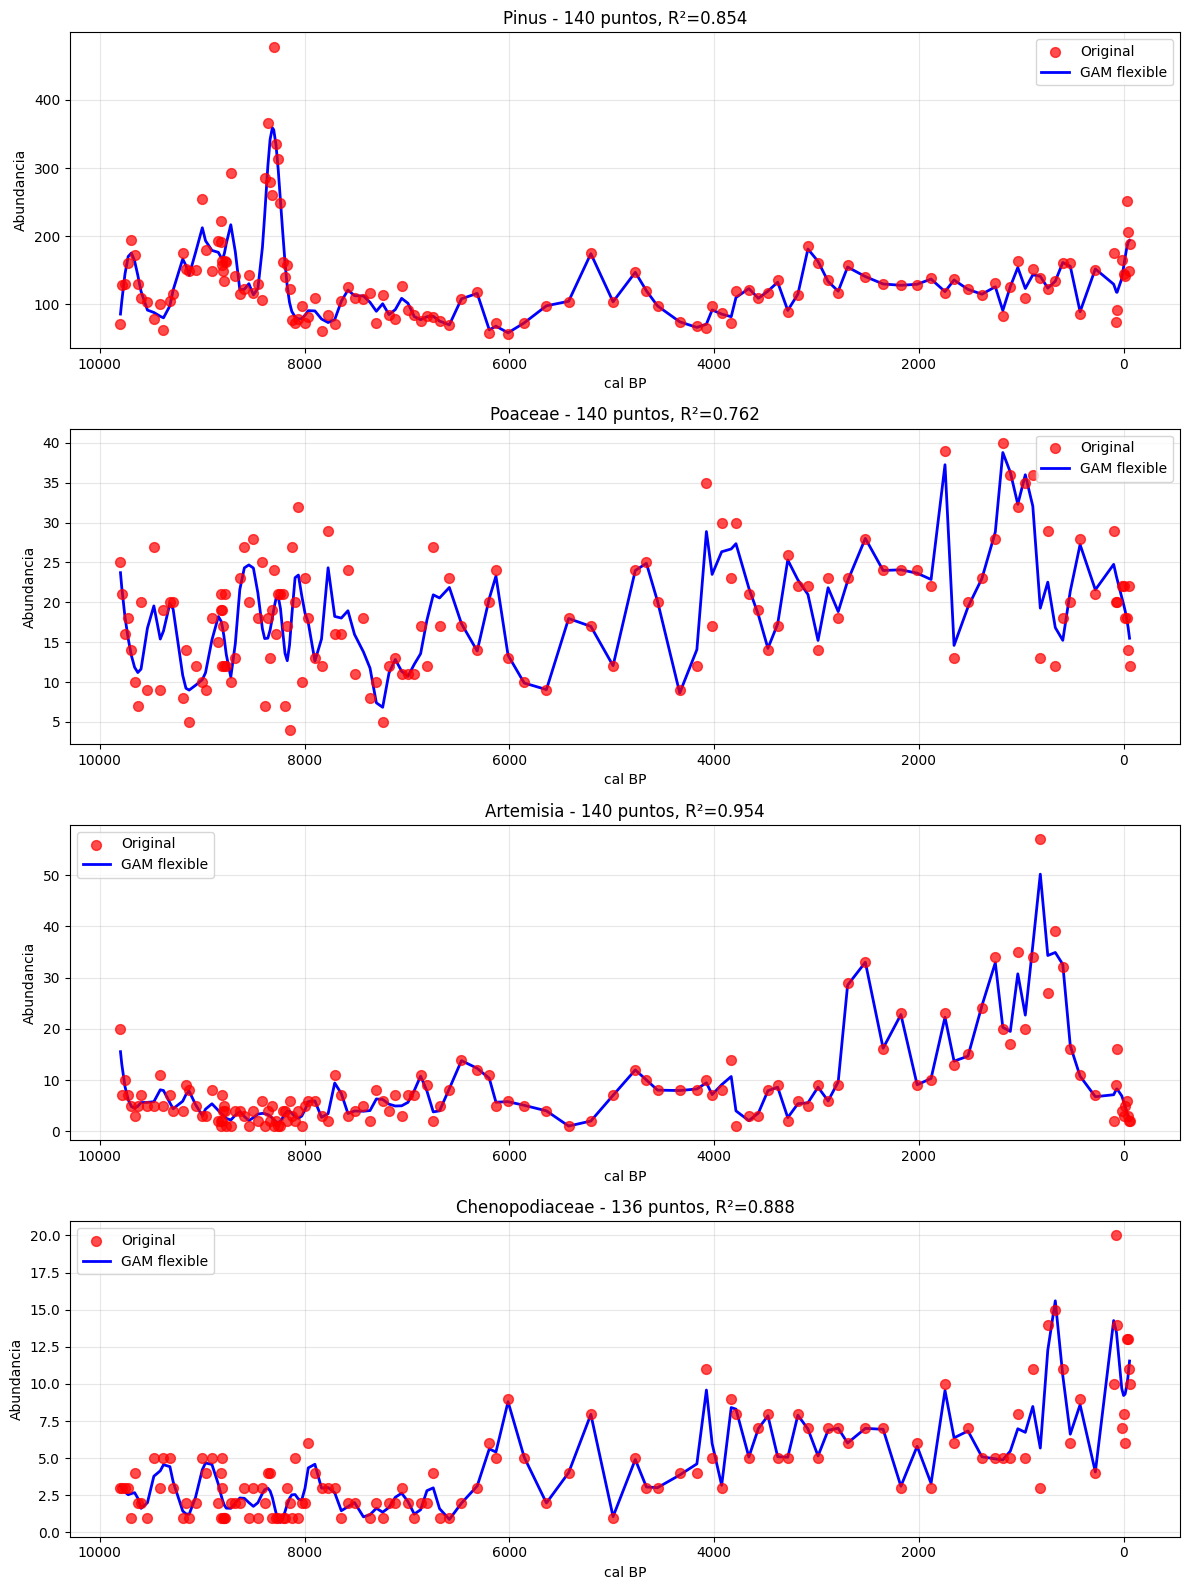


Especies válidas para análisis: 74

Analizando ventana 0_50...
  0_50: 589/5402 significativos (10.90%)

Analizando ventana 51_84...
  51_84: 645/5401 significativos (11.94%)

Analizando ventana 85_140...
  85_140: 1173/5402 significativos (21.71%)

RESULTADOS FINALES

0_50:
  Total: 5402 pares
  Significativos: 589 (10.90%)
    Positivos: 331 (56.2%)
    Negativos: 258 (43.8%)

51_84:
  Total: 5401 pares
  Significativos: 645 (11.94%)
    Positivos: 325 (50.4%)
    Negativos: 320 (49.6%)

85_140:
  Total: 5402 pares
  Significativos: 1173 (21.71%)
    Positivos: 565 (48.2%)
    Negativos: 608 (51.8%)

=== RECONSTRUYENDO CON GAM CONTROLADO ===
  Procesando especie 1/79
  Procesando especie 21/79
  Procesando especie 41/79
  Procesando especie 61/79

VENTANA: 0_50
Especies activas: 76

RESULTADOS 0_50:
  Pares analizados: 306
  Links significativos (p<0.01): 28
  Porcentaje: 9.15%
  Media p-value: 0.3685
  Mediana p-value: 0.2922
  Distribución:
    p<0.01: 28
    0.01-0.05: 34
    0.0

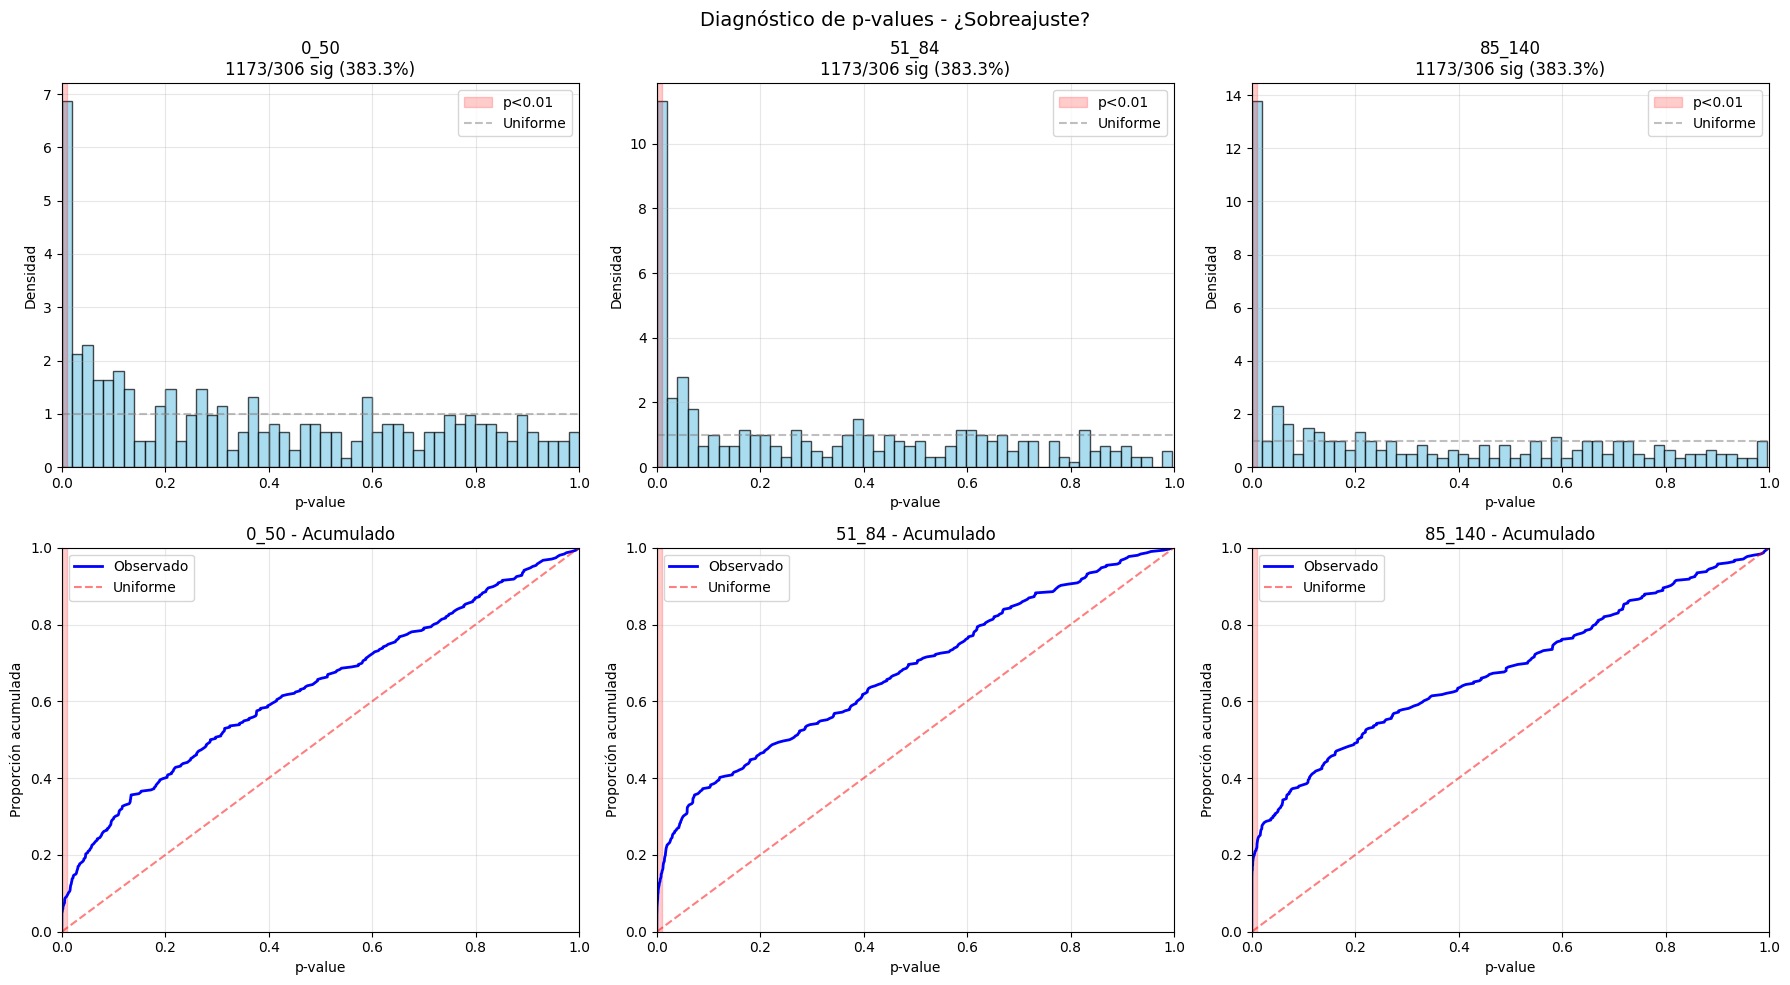

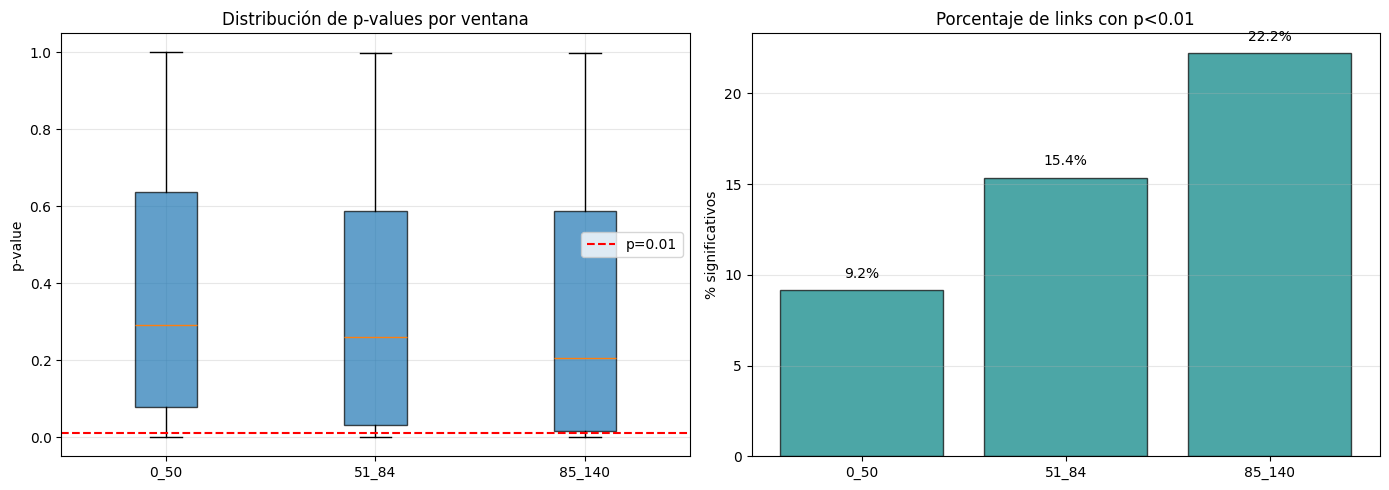


RESUMEN GLOBAL

Total p-values analizados: 918
Media global: 0.3362
Mediana global: 0.2564
p<0.01: 143 (15.58%)
p<0.05: 248 (27.02%)
p<0.1: 320 (34.86%)

Test de Kolmogorov-Smirnov (vs uniforme):
  Estadístico: 0.2612
  p-value: 0.0000
  ⚠️ La distribución NO es uniforme (hay estructura/sobreajuste)


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')

# ============================================
# CONFIGURACIÓN - MÁS FLEXIBLE
# ============================================

windows = {
    "0_50": (0, 50),
    "51_84": (51, 84),
    "85_140": (85, 140)
}

especies_cols = df_bas.columns[df_bas.columns.get_loc('Abies'):].tolist()
print(f"Total especies: {len(especies_cols)}")

# PARÁMETROS - MÁS FLEXIBLES (menos suave)
UMBRAL_P_VALUE = 0.01
MIN_PUNTOS_ESPECIE = 5

# GAM - MÁS FLEXIBLE
N_SPLINES_BASE = 130       
LAMBDA_GAM = 0.01           
USE_GRIDSEARCH = False      # Buscar lambda óptimo
SPLINES_POR_PUNTOS = 1     # Splines = n_puntos / este valor

print(f"\nParámetros MÁS FLEXIBLES:")
print(f"  Umbral p-value: {UMBRAL_P_VALUE}")
print(f"  Mínimo puntos: {MIN_PUNTOS_ESPECIE}")
print(f"  Splines base: {N_SPLINES_BASE}")
print(f"  Lambda: {LAMBDA_GAM} (bajo = más flexible)")
print(f"  Grid search: {USE_GRIDSEARCH}")
print(f"  Splines adaptativos: 1 punto cada {SPLINES_POR_PUNTOS} splines")
print("="*60)

def convertir_ceros_a_nan(df):
    df_mod = df.copy()
    for col in especies_cols:
        df_mod[col] = df_mod[col].replace(0, np.nan)
    return df_mod

def reconstruir_serie_flexible(df_original):
    """
    Reconstruye con GAM usando parámetros flexibles
    """
    tiempo = df_original['cal BP'].values
    df_reconstruido = df_original.copy()
    
    print("\n=== RECONSTRUYENDO CON GAM FLEXIBLE ===")
    
    estadisticas = []
    
    for idx, sp in enumerate(especies_cols):
        if idx % 10 == 0:
            print(f"  Procesando especie {idx+1}/{len(especies_cols)}")
            
        serie = df_original[sp].copy()
        mascara_valida = ~np.isnan(serie)
        n_puntos = mascara_valida.sum()
        
        if n_puntos < MIN_PUNTOS_ESPECIE:
            continue
            
        tiempo_valido = tiempo[mascara_valida].reshape(-1, 1)
        valores_validos = serie[mascara_valida].values
        
        try:
            # Calcular número de splines adaptativo
            n_splines_adaptativo = min(
                N_SPLINES_BASE,
                max(5, n_puntos // SPLINES_POR_PUNTOS)
            )
            
            # Crear GAM
            gam = LinearGAM(s(0, n_splines=n_splines_adaptativo))
            
            if USE_GRIDSEARCH and n_puntos > 15:
                # Búsqueda de lambda en un rango
                lam_range = np.logspace(-3, 3, 20)  # De muy flexible a muy suave
                print(f"    {sp}: buscando lambda óptimo con {n_splines_adaptativo} splines...")
                gam.gridsearch(tiempo_valido, valores_validos, lam=lam_range, progress=False)
                lambda_opt = gam.lam[0][0]
            else:
                gam.lam = LAMBDA_GAM
                gam.fit(tiempo_valido, valores_validos)
                lambda_opt = LAMBDA_GAM
            
            # Predecir
            tiempo_completo = tiempo.reshape(-1, 1)
            predicciones = gam.predict(tiempo_completo)
            predicciones = np.maximum(predicciones, 0)
            
            # Guardar
            df_reconstruido[sp] = predicciones
            
            # Métricas
            pred_validos = gam.predict(tiempo_valido)
            residuos = valores_validos - pred_validos
            rmse = np.sqrt(np.mean(residuos**2))
            r2 = 1 - np.var(residuos) / np.var(valores_validos) if np.var(valores_validos) > 0 else 0
            
            estadisticas.append({
                'especie': sp,
                'puntos': n_puntos,
                'splines': n_splines_adaptativo,
                'lambda': f'{lambda_opt:.4f}',
                'rmse': f'{rmse:.3f}',
                'r2': f'{r2:.3f}'
            })
            
        except Exception as e:
            # Fallback a interpolación con suavizado
            print(f"    ⚠️ {sp}: usando fallback")
            from scipy.interpolate import UnivariateSpline
            try:
                spline = UnivariateSpline(tiempo_valido.flatten(), valores_validos, s=len(valores_validos))
                predicciones = spline(tiempo)
                predicciones = np.maximum(predicciones, 0)
                df_reconstruido[sp] = predicciones
            except:
                df_reconstruido[sp] = np.mean(valores_validos)
    
    # Mostrar estadísticas
    if estadisticas:
        df_stats = pd.DataFrame(estadisticas)
        print("\nEstadísticas de ajuste:")
        print(f"  R² promedio: {df_stats['r2'].astype(float).mean():.3f}")
        print(f"  RMSE promedio: {df_stats['rmse'].astype(float).mean():.3f}")
        print(f"  Splines promedio: {df_stats['splines'].astype(float).mean():.1f}")
        
        # Mostrar algunas especies
        print("\nEjemplos de ajuste:")
        print(df_stats.head(10).to_string(index=False))
    
    return df_reconstruido

def visualizar_ajuste(df_original, df_reconstruido, especies_ejemplo):
    """
    Visualiza el ajuste para verificar flexibilidad
    """
    tiempo = df_original['cal BP'].values
    
    n_plots = len(especies_ejemplo)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4*n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    for idx, sp in enumerate(especies_ejemplo):
        ax = axes[idx]
        
        # Datos originales
        original = df_original[sp].values
        mask = ~np.isnan(original)
        
        # Datos reconstruidos
        reconstruido = df_reconstruido[sp].values
        
        # Plot
        ax.scatter(tiempo[mask], original[mask], 
                  color='red', s=50, alpha=0.7, label='Original', zorder=5)
        ax.plot(tiempo, reconstruido, 'b-', linewidth=2, label='GAM flexible', zorder=3)
        
        # Estadísticas
        if mask.sum() > 2:
            r2 = np.corrcoef(original[mask], reconstruido[mask])[0,1]**2
            ax.set_title(f'{sp} - {mask.sum()} puntos, R²={r2:.3f}')
        else:
            ax.set_title(f'{sp} - {mask.sum()} puntos')
        
        ax.set_xlabel('cal BP')
        ax.set_ylabel('Abundancia')
        ax.invert_xaxis()
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('ajuste_gam_flexible.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================
# EJECUCIÓN
# ============================================

# Preparar datos
df_con_nan = convertir_ceros_a_nan(df_bas)

# Reconstruir con GAM flexible
df_reconstruido = reconstruir_serie_flexible(df_con_nan)

# Visualizar algunas especies para ver el ajuste
especies_para_ver = ['Pinus', 'Quercus', 'Poaceae', 'Artemisia', 'Chenopodiaceae']
especies_disponibles = [sp for sp in especies_para_ver if sp in especies_cols]
if especies_disponibles:
    visualizar_ajuste(df_con_nan, df_reconstruido, especies_disponibles)

# Especies válidas
especies_validas = [sp for sp in especies_cols if df_con_nan[sp].count() >= MIN_PUNTOS_ESPECIE]
print(f"\nEspecies válidas para análisis: {len(especies_validas)}")

# Calcular Granger
resultados = {}
for window_name, (start, end) in windows.items():
    df_window = df_reconstruido.iloc[start:end+1].copy()
    
    print(f"\nAnalizando ventana {window_name}...")
    
    resultados_ventana = []
    total_pares = len(especies_validas) * (len(especies_validas) - 1)
    
    for i, sp1 in enumerate(especies_validas):
        for j, sp2 in enumerate(especies_validas):
            if i != j:
                try:
                    array_x = df_window[sp1].values[::-1]
                    array_y = df_window[sp2].values[::-1]
                    
                    array_x = array_x + np.random.normal(0, 1e-8, len(array_x))
                    array_y = array_y + np.random.normal(0, 1e-8, len(array_y))
                    
                    data = pd.DataFrame({sp1: array_x, sp2: array_y})
                    scaler = StandardScaler()
                    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
                    
                    model = VAR(data_scaled)
                    results = model.fit(maxlags=1)
                    
                    causality = results.test_causality(caused=sp2, causing=[sp1], kind='f')
                    p_value = causality.pvalue
                    coeficiente = results.coefs[0][1][0]
                    
                    resultados_ventana.append({
                        'from': sp1,
                        'to': sp2,
                        'p_value': p_value,
                        'coeficiente': coeficiente,
                        'signo': 'positivo' if coeficiente > 0 else 'negativo'
                    })
                    
                except:
                    continue
    
    resultados[window_name] = pd.DataFrame(resultados_ventana)
    
    # Mostrar resultados
    df_res = resultados[window_name]
    if len(df_res) > 0:
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        print(f"  {window_name}: {len(sig)}/{len(df_res)} significativos ({len(sig)/len(df_res)*100:.2f}%)")

# Tabla final
print("\n" + "="*60)
print("RESULTADOS FINALES")
print("="*60)

for window_name, df_res in resultados.items():
    if len(df_res) > 0:
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        n_sig = len(sig)
        pct_sig = n_sig/len(df_res)*100
        
        if n_sig > 0:
            n_pos = len(sig[sig['signo'] == 'positivo'])
            n_neg = len(sig[sig['signo'] == 'negativo'])
            print(f"\n{window_name}:")
            print(f"  Total: {len(df_res)} pares")
            print(f"  Significativos: {n_sig} ({pct_sig:.2f}%)")
            print(f"    Positivos: {n_pos} ({n_pos/n_sig*100:.1f}%)")
            print(f"    Negativos: {n_neg} ({n_neg/n_sig*100:.1f}%)")


def calcular_granger_con_histogramas(df_reconstruido):
    """
    Calcula Granger y genera histogramas detallados
    """
    resultados = {}
    todos_p_values = []
    
    for window_name, (start, end) in windows.items():
        print(f"\n{'='*50}")
        print(f"VENTANA: {window_name}")
        print(f"{'='*50}")
        
        df_window = df_reconstruido.iloc[start:end+1].copy()
        
        # Seleccionar especies con datos
        especies_activas = []
        for sp in especies_cols:
            if not np.all(df_window[sp] == df_window[sp].iloc[0]):  # No constante
                especies_activas.append(sp)
        
        print(f"Especies activas: {len(especies_activas)}")
        
        if len(especies_activas) < 2:
            resultados[window_name] = pd.DataFrame()
            continue
        
        # Calcular pares
        p_values = []
        
        for i, sp1 in enumerate(especies_activas[:20]):  # Limitar para prueba
            for j, sp2 in enumerate(especies_activas[:20]):
                if i != j:
                    try:
                        array_x = df_window[sp1].values[::-1]
                        array_y = df_window[sp2].values[::-1]
                        
                        array_x = array_x + np.random.normal(0, 1e-8, len(array_x))
                        array_y = array_y + np.random.normal(0, 1e-8, len(array_y))
                        
                        data = pd.DataFrame({sp1: array_x, sp2: array_y})
                        scaler = StandardScaler()
                        data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
                        
                        model = VAR(data_scaled)
                        results = model.fit(maxlags=1)
                        
                        causality = results.test_causality(caused=sp2, causing=[sp1], kind='f')
                        p_value = causality.pvalue
                        
                        p_values.append(p_value)
                        todos_p_values.append(p_value)
                        
                    except:
                        continue
        
        df_res = pd.DataFrame({'p_value': p_values})
        resultados[window_name] = df_res
        
        # Estadísticas de esta ventana
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        print(f"\nRESULTADOS {window_name}:")
        print(f"  Pares analizados: {len(df_res)}")
        print(f"  Links significativos (p<0.01): {len(sig)}")
        print(f"  Porcentaje: {len(sig)/len(df_res)*100:.2f}%")
        print(f"  Media p-value: {df_res['p_value'].mean():.4f}")
        print(f"  Mediana p-value: {df_res['p_value'].median():.4f}")
        
        # Distribución
        print(f"  Distribución:")
        print(f"    p<0.01: {len(df_res[df_res['p_value']<0.01])}")
        print(f"    0.01-0.05: {len(df_res[(df_res['p_value']>=0.01) & (df_res['p_value']<0.05)])}")
        print(f"    0.05-0.1: {len(df_res[(df_res['p_value']>=0.05) & (df_res['p_value']<0.1)])}")
        print(f"    0.1-0.5: {len(df_res[(df_res['p_value']>=0.1) & (df_res['p_value']<0.5)])}")
        print(f"    0.5-1.0: {len(df_res[df_res['p_value']>=0.5])}")
    
    return resultados, todos_p_values

# ============================================
# VISUALIZACIÓN DE HISTOGRAMAS
# ============================================

def plotear_histogramas_comparativos(resultados_gam, resultados_sin_gam=None):
    """
    Visualiza histogramas de p-values para diagnosticar
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Fila superior: histogramas normales
    for idx, (window_name, df_res) in enumerate(resultados_gam.items()):
        if len(df_res) == 0:
            continue
            
        ax = axes[0, idx]
        
        # Histograma con bins más finos
        n, bins, patches = ax.hist(df_res['p_value'], bins=50, edgecolor='black', 
                                   alpha=0.7, color='skyblue', density=True)
        
        # Destacar región significativa
        ax.axvspan(0, UMBRAL_P_VALUE, alpha=0.2, color='red', label=f'p<{UMBRAL_P_VALUE}')
        
        # Línea de distribución uniforme (esperada bajo null)
        ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Uniforme')
        
        ax.set_xlabel('p-value')
        ax.set_ylabel('Densidad')
        ax.set_title(f'{window_name}\n{n_sig}/{len(df_res)} sig ({n_sig/len(df_res)*100:.1f}%)')
        ax.set_xlim(0, 1)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Fila inferior: histogramas acumulados
    for idx, (window_name, df_res) in enumerate(resultados_gam.items()):
        if len(df_res) == 0:
            continue
            
        ax = axes[1, idx]
        
        # Ordenar p-values
        p_sorted = np.sort(df_res['p_value'])
        y = np.arange(1, len(p_sorted)+1) / len(p_sorted)
        
        # Línea acumulada
        ax.plot(p_sorted, y, 'b-', linewidth=2, label='Observado')
        
        # Línea de uniforme (diagonal)
        ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Uniforme')
        
        # Área de significancia
        ax.axvspan(0, UMBRAL_P_VALUE, alpha=0.2, color='red')
        
        ax.set_xlabel('p-value')
        ax.set_ylabel('Proporción acumulada')
        ax.set_title(f'{window_name} - Acumulado')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Diagnóstico de p-values - ¿Sobreajuste?', fontsize=14)
    plt.tight_layout()
    plt.savefig('histogramas_diagnostico.png', dpi=300, bbox_inches='tight')
    plt.show()

def plotear_comparacion_ventanas(resultados_gam):
    """
    Compara la distribución de p-values entre ventanas
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot de p-values por ventana
    ax1 = axes[0]
    data_box = [df_res['p_value'].values for name, df_res in resultados_gam.items() if len(df_res) > 0]
    labels = [name for name, df_res in resultados_gam.items() if len(df_res) > 0]
    
    bp = ax1.boxplot(data_box, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_alpha(0.7)
    ax1.axhline(y=UMBRAL_P_VALUE, color='red', linestyle='--', label=f'p={UMBRAL_P_VALUE}')
    ax1.set_ylabel('p-value')
    ax1.set_title('Distribución de p-values por ventana')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Porcentaje de significativos
    ax2 = axes[1]
    ventanas = []
    pcts_sig = []
    
    for window_name, df_res in resultados_gam.items():
        if len(df_res) > 0:
            ventanas.append(window_name)
            sig_pct = len(df_res[df_res['p_value'] < UMBRAL_P_VALUE]) / len(df_res) * 100
            pcts_sig.append(sig_pct)
    
    bars = ax2.bar(ventanas, pcts_sig, color='teal', alpha=0.7, edgecolor='black')
    ax2.set_ylabel('% significativos')
    ax2.set_title(f'Porcentaje de links con p<{UMBRAL_P_VALUE}')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Añadir etiquetas
    for bar, pct in zip(bars, pcts_sig):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('comparacion_ventanas.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================
# EJECUCIÓN PRINCIPAL
# ============================================

# 1. Preparar datos
df_con_nan = convertir_ceros_a_nan(df_bas)

# 2. Reconstruir con GAM controlado
df_reconstruido = reconstruir_con_gam_controlado(df_con_nan)

# 3. Calcular Granger con histogramas
resultados_gam, todos_p_values = calcular_granger_con_histogramas(df_reconstruido)

# 4. Visualizar diagnóstico
plotear_histogramas_comparativos(resultados_gam)
plotear_comparacion_ventanas(resultados_gam)

# 5. Resumen global
print("\n" + "="*60)
print("RESUMEN GLOBAL")
print("="*60)

todos_p = np.array(todos_p_values)
print(f"\nTotal p-values analizados: {len(todos_p)}")
print(f"Media global: {todos_p.mean():.4f}")
print(f"Mediana global: {np.median(todos_p):.4f}")
print(f"p<0.01: {len(todos_p[todos_p<0.01])} ({len(todos_p[todos_p<0.01])/len(todos_p)*100:.2f}%)")
print(f"p<0.05: {len(todos_p[todos_p<0.05])} ({len(todos_p[todos_p<0.05])/len(todos_p)*100:.2f}%)")
print(f"p<0.1: {len(todos_p[todos_p<0.1])} ({len(todos_p[todos_p<0.1])/len(todos_p)*100:.2f}%)")

# Prueba de uniformidad (Kolmogorov-Smirnov)
from scipy import stats
ks_statistic, ks_pvalue = stats.kstest(todos_p, 'uniform')
print(f"\nTest de Kolmogorov-Smirnov (vs uniforme):")
print(f"  Estadístico: {ks_statistic:.4f}")
print(f"  p-value: {ks_pvalue:.4f}")
if ks_pvalue < 0.05:
    print("  ⚠️ La distribución NO es uniforme (hay estructura/sobreajuste)")
else:
    print("  ✅ La distribución es compatible con uniforme")